In [88]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

import matplotlib
from pcygni_profile import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time
import pickle
import corner

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

from scipy.integrate import quad
def integral(x): 
    return np.sqrt(1-v**2) * 1/(1-v*np.cos(x))*np.sin(x)*np.cos(x)**2 * (3) 

#n_days = np.array([126000, 212400, 298800, 385200])/86400
#n_days = np.array([1.43, 2.42, 3.41, 4.4])
#n_days = np.array([1.43, 2.42, 3.45, 4.4, 5.4])

#beta, doppler = np.loadtxt('doppler_wo_prolate.txt')
#inter = interp1d(beta, doppler)

beta1, doppler1 = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta1, doppler1)

#beta1, doppler1 = np.loadtxt('doppler_wo_prolate_use_to_the_fourth.txt')
#inter = interp1d(beta1, doppler1)


#beta, doppler = np.loadtxt('doppler_incl_temp_40.txt')
#inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    #delta = (1-vphot**2)**(1/2) * 1/(1-vphot)
    #delta = (1-vphot**2)**(-1/2) * (1-vphot)
    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
        
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse
    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc


# Grid points in distance and inclination (theta_jn)
XX = np.loadtxt('./Inclination/figure_4/incl_grid_pts.dat.gz')
YY = np.loadtxt('./Inclination/figure_4/dist_grid_pts.dat.gz')

# Posterior PDF values for the marginal distributions shown in Figure 4
gw_Z = np.loadtxt('./Inclination/figure_4/volumetric_marginal_posterior_pdf.dat.gz')
em_Z = np.loadtxt('./Inclination/figure_4/em_dist_prior_marginal_posterior_pdf.dat.gz')

theta_jns = XX[0, :]; 
dists = YY[:, 0]
d_theta_jn = theta_jns[1] - theta_jns[0]
ourprior = 1/np.sqrt(2*np.pi*7**2)*np.exp(-((180-XX)-21)**2/(2*7)**2)

#plt.plot(dists, d_theta_jn*np.sum(em_Z, axis=0), label='GW prior')
#plt.plot(dists, d_theta_jn*np.sum(gw_Z, axis=1), label='GW prior')
y = d_theta_jn*np.sum(ourprior*gw_Z, axis=0)
norm = np.trapz(y, dists )
#plt.plot(dists, y/norm, label='GW prior')

#### Datasets: 

###### OB1: 
"./data/OB2/OB1_fixed_ve_dl_40_large.pkl" - fixed ve = 0.057 single P-cygni

###### OB2: 
"./data/OB2/OB2_3_peaks_fixed_ve.pkl" - fixed ve = 0.11

###### OB3: 
"./data/OB3/OB3_3_peaks_large.pkl" - hits ceiling of ve=1

###### OB4: 
"./Data/OB4/OB4_3_peaks.pkl" - free ve (huge uncertainties, may need longer chain)

0.2798931968922678
Lum_dist =  43.283514983717794 + 0.0798572190084954 - 0.07598833577250019
<Parameter 've', value=0.3127667868694095 +/- 0.0467, bounds=[0:1]>
1.3391756106371648e-29
0.24808142478639736
Lum_dist =  43.08304261587324 + 0.13940569654445056 - 0.1352500465128159
<Parameter 've', value=0.7257080469406663 +/- 0.182, bounds=[0:1]>
2.791868985489651e-29


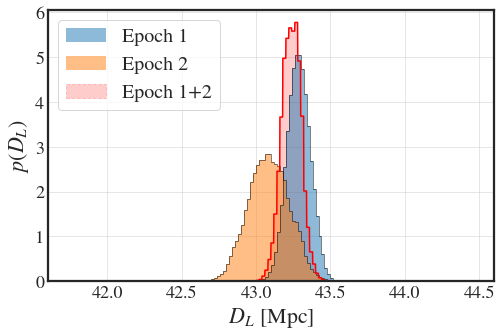

In [2]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]
n_days = [1.43, 2.422, 3.42, 4.40, 5.40]

files = ["./data/OB1/OB1_3_peaks_100walkers.pkl", "./data/OB2/OB2_3_peaks_100walkers.pkl", 
         "./data/OB3/OB3_3_peaks_filtered_3.pkl", "./Data/OB4/OB4_3_peaks_filtered.pkl", 
         "./Data/OB5/OB5_3_filtered_short.pkl" ] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
plt.figure(figsize=(8,5))
    
steady = [22*100, 25*100, 22*1000, 22*100, 22*3000]

d_m, ds_1, ds_2 = [], [], []
multi = np.ones(5) 
#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []
for idx, file in enumerate(files[:2]):
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['T'])
    #print(emcee_res.params['vphot'])
    
    vphot = np.array(emcee_flatten['vphot'])*np.random.uniform(low=1.4292, high=1.4308, size=len(emcee_flatten['vphot']))/1.43
    print(np.median(vphot))
    #*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['vphot']))
        
    dl = lum_dist_arr(np.array(emcee_flatten['N']), 
                                                                    vphot, n_days=n_days[idx])[steady[idx]:]*multi[idx]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h1 = plt.hist(dl, bins=150, histtype='stepfilled', density=True,
                 label='Epoch '+str(idx+1), range=(42,45), alpha=0.5)
    h1 = plt.hist(dl, bins=150, histtype='step', density=True,
                 range=(42,45), color='k', alpha=0.5)
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h1[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    print(emcee_res.params['ve'])
    print(np.median(emcee_flatten['N']))

d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.xlabel(r'$D_L$ [Mpc]'), plt.ylabel(r'$p(D_L)$') 
#plt.xlim(35, 47)
plt.xlim(41.6, 44.6)

p1,p2 = pdf_list
dh = h1[1][1]-h1[1][0]
#plt.plot(h[1][1:], p1*p2/np.sum(p1*p2*dh))
plt.plot(np.linspace(43, 44.5, 1000), 
         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(43, 44.5, 1000))
         , color='red', alpha=1 )
plt.fill_between(np.linspace(43, 44.5, 1000), 
         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(43, 44.5, 1000)), 
                 color='red', ls='--', alpha=0.2, label='Epoch 1+2' )

sig1 = abs(ds_1+ds_2)/2
sigma = np.sum(1/sig1**2)**(-1/2)
mu = np.sum(1/sig1**2/np.sum(1/sig1**2)*d_m)

combined = 1/np.sqrt(2*np.pi*sigma**2)*np.exp( -(np.linspace(42.9, 44, 100)-mu)**2/(2*sigma**2))
#plt.plot( np.linspace(42.9, 44, 100), 
#         combined, color='red', ls='--', alpha=1)
#plt.fill_between( np.linspace(42.9, 44, 100), 
#         combined, color='red', ls='--', alpha=0.2, label='Epoch 1+2')

plt.legend(frameon=True, fontsize=20, loc=2)
#plt.savefig('Pictures/dl_dist_8.png', dpi=300)

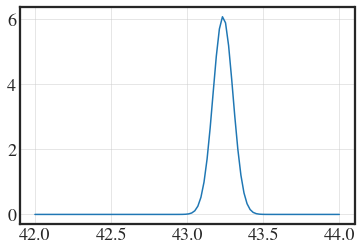

### Describe $\chi^2$-squares

0.27954092652954726 0.2798932114605146
Occult= 0.038394064353415844
Lum_dist =  43.28463853233123 + 0.33705965501714985 - 0.3292691605175335
<Parameter 've', value=0.3127667868694095 +/- 0.0467, bounds=[0:1]>
1.3391756106371648e-29
0.24763280570541202 0.24808001429652052
Occult= 1.3053866710215676
Lum_dist =  43.048337995840654 + 0.3533524948914888 - 0.346067161235716
<Parameter 've', value=0.7257080469406663 +/- 0.182, bounds=[0:1]>
2.791868985489651e-29
0.20376243940232913 0.20397601390780323
Occult= 3.5282757368413553
Lum_dist =  40.23572724729267 + 0.35493121231415614 - 0.34349327387123907
<Parameter 've', value=6.626496794247202 +/- 2.32, bounds=[0:10]>
3.817335296521477e-29
0.1723608324355996 0.17304530867385287
Occult= 7.656267982349197
Lum_dist =  45.92362972076819 + 0.4617887082372647 - 0.4526475890795396
<Parameter 've', value=7.104226961196531 +/- 3.54, bounds=[0:10]>
3.2010461509524127e-29
0.148588547415522 0.1487510652639866
Occult= 19.885019152196143
Lum_dist =  43.933286

(35.0, 48.0)

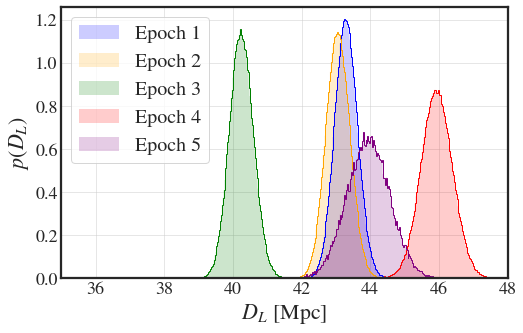

In [3]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]
n_days = [1.43, 2.42, 3.42, 4.40, 5.40]

files = ["./data/OB1/OB1_3_peaks_100walkers.pkl", "./data/OB2/OB2_3_peaks_100walkers.pkl", 
         "./data/OB3/OB3_3_peaks_filtered_3.pkl", "./Data/OB4/OB4_3_peaks_filtered.pkl", 
         "./Data/OB5/OB5_3_filtered_short.pkl" ] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
plt.figure(figsize=(8,5))
    
steady = [22*100, 25*100, 22*1000, 22*100, 22*3000]

d_m, ds_1, ds_2 = [], [], []
multi_1=np.array([1, 1, 1, 1, 1])
multi = [0.015, 0.015, 0.017, 0.017, 0.025]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
color_list = ['blue', 'orange', 'green', 'red', 'purple']
#multi = np.ones(5) 

#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []
for idx, file in enumerate(files):
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['T'])
    #print(emcee_res.params['vphot'])
    
    vphot = np.array(emcee_flatten['vphot'])
    print(np.percentile(vphot, 16.9),np.median(vphot))
    print('Occult=',np.median(np.array(emcee_flatten['occult'])))
    #*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['vphot']))
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = plt.hist(dl, bins=500, histtype='step', density=True, range=(37,50), color=color_list[idx])
    h = plt.hist(dl, bins=500, histtype='stepfilled', alpha=0.2,
                 density=True, label='Epoch '+str(idx+1), range=(37,50), color=color_list[idx])
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    print(emcee_res.params['ve'])
    print(np.median(emcee_flatten['N']))

d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.legend(frameon=True, fontsize=20, loc=2)
plt.xlabel(r'$D_L$ [Mpc]'), plt.ylabel(r'$p(D_L)$') 
#plt.xlim(35, 47)
plt.xlim(35, 48)

#plt.savefig('Pictures/dl_dist_5_1.png', dpi=300)

0.15528329320931938 0.15643524908648707
Occult= 7.713599721736371
Lum_dist =  41.09887155807173 + 0.5395667775344251 - 0.5228034813073634
<Parameter 've', value=10.769461133136815 +/- 5.33, bounds=[0:20]>
3.120739634650253e-29
0.13386583301627825 0.13525350484722395
Occult= 19.852905575860014
Lum_dist =  39.82861514745976 + 0.669633271614174 - 0.6493803741745268
<Parameter 've', value=0.1709566773834896 +/- 0.0129, bounds=[0:20]>
3.5266690413409803e-29


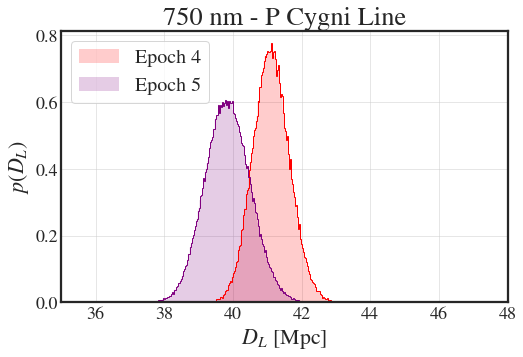

In [86]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]
n_days = [1.43, 2.42, 3.4, 4.40, 5.40]

files = ["./Data/OB4/OB4_two_Pcygni_28x5000.pkl" , "./Data/OB5/OB5_two_Pcygni_28x10000_lambda0_7500.pkl"] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
plt.figure(figsize=(8,5))
    
steady = [22*100, 25*100, 22*1000, 28*500, 28*1500]

d_m, ds_1, ds_2 = [], [], []
multi_1=np.array([1, 1, 1, 1, 1])
multi = [0.015, 0.015, 0.017, 0.017, 0.025]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
color_list = ['blue', 'orange', 'green', 'red', 'purple']
#multi = np.ones(5) 

#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []
for idx, file in enumerate(files):
    idx = idx+3
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['T'])
    #print(emcee_res.params['vphot'])
    
    vphot = np.array(emcee_flatten['v_phot_n'])#+0.01
    print(np.percentile(vphot, 16.9),np.median(vphot))
    print('Occult=',np.median(np.array(emcee_flatten['occult'])))
    #*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['vphot']))
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = plt.hist(dl, bins=500, histtype='step', density=True, range=(37,50), color=color_list[idx])
    h = plt.hist(dl, bins=500, histtype='stepfilled', alpha=0.2,
                 density=True, label='Epoch '+str(idx+1), range=(37,50), color=color_list[idx])
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    print(emcee_res.params['ve'])
    print(np.median(emcee_flatten['N']))

d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.legend(frameon=True, fontsize=20, loc=2)
plt.xlabel(r'$D_L$ [Mpc]'), plt.ylabel(r'$p(D_L)$') 
#plt.xlim(35, 47)
plt.xlim(35, 48)
plt.title('750 nm - P Cygni Line')
#ax.ticklabel_format(style='plain')

plt.ticklabel_format(axis="y", style="plain", scilimits=(0,0))
#plt.savefig('Pictures/dl_dist_750_PCygni.png', dpi=300)

0.1672133528815598 0.16876376279883673
Occult= 7.532630747519235
Lum_dist =  45.159443867105765 + 0.7688717568785464 - 0.7127451744534881
<Parameter 've', value=12.032170426234178 +/- 4.82, bounds=[0:20]>
3.1204865728902563e-29
0.13386583301627825 0.13525350484722395
Occult= 19.852905575860014
Lum_dist =  39.831544738336845 + 0.8314345985973688 - 0.8008415259660282
<Parameter 've', value=0.1709566773834896 +/- 0.0129, bounds=[0:20]>
3.5266690413409803e-29


Text(0.5, 1.0, '760 nm - P Cygni Line')

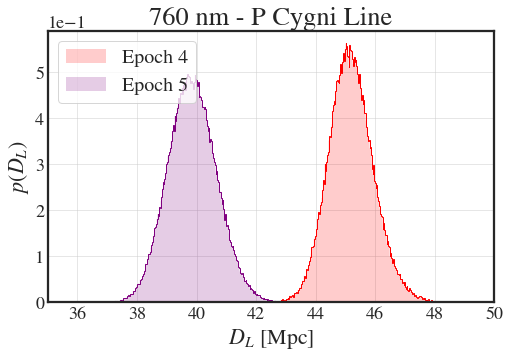

In [105]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]
n_days = [1.43, 2.42, 3.4, 4.40, 5.40]

files = ["./Data/OB4/OB4_two_Pcygni_28x2500_lambda0_7600.pkl" , "./Data/OB5/OB5_two_Pcygni_28x10000_lambda0_7500.pkl"] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
plt.figure(figsize=(8,5))
    
steady = [22*100, 25*100, 22*1000, 28*500, 28*1500]

d_m, ds_1, ds_2 = [], [], []
multi_1=np.array([1, 1, 1, 1, 1])
multi = [0.015, 0.015, 0.017, 0.025, 0.035]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
color_list = ['blue', 'orange', 'green', 'red', 'purple']
#multi = np.ones(5) 

#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []
for idx, file in enumerate(files):
    idx = idx+3
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['T'])
    #print(emcee_res.params['vphot'])
    
    #vphot = np.array(emcee_flatten['vphot'])
    vphot = np.array(emcee_flatten['v_phot_n'])
    print(np.percentile(vphot, 16.9),np.median(vphot))
    print('Occult=',np.median(np.array(emcee_flatten['occult'])))
    #*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['vphot']))
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = plt.hist(dl, bins=500, histtype='step', density=True, range=(37,50), color=color_list[idx])
    h = plt.hist(dl, bins=500, histtype='stepfilled', alpha=0.2,
                 density=True, label='Epoch '+str(idx+1), range=(37,50), color=color_list[idx])
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    print(emcee_res.params['ve'])
    print(np.median(emcee_flatten['N']))

d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.legend(frameon=True, fontsize=20, loc=2)
plt.xlabel(r'$D_L$ [Mpc]'), plt.ylabel(r'$p(D_L)$') 
#plt.xlim(35, 47)
plt.xlim(35, 50)
plt.title('760 nm - P Cygni Line')

#plt.savefig('Pictures/dl_dist_5_1.png', dpi=300)

0.16064694929325601 0.16182598125516912
Occult= 7.599018316448197
Lum_dist =  42.77257693831132 + 0.5574678101224464 - 0.5329398325693262
<Parameter 've', value=12.82263338734781 +/- 4.35, bounds=[0:20]>
3.1252946623675175e-29
0.14227387290271515 0.1436969104522136
Occult= 19.93129485642831
Lum_dist =  43.052760721097314 + 0.8882689458659527 - 0.8830709849043217
<Parameter 've', value=0.15884139608872536 +/- 0.00987, bounds=[0:20]>
3.512480614875055e-29


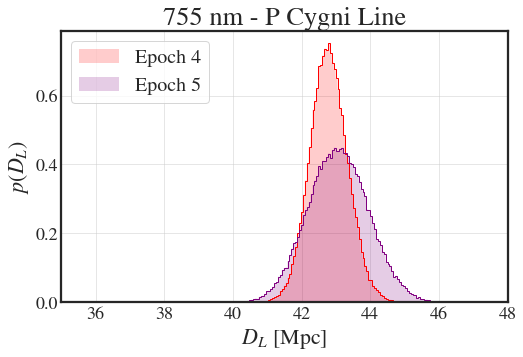

In [103]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]
n_days = [1.43, 2.42, 3.4, 4.40, 5.40]

files = ["./Data/OB4/OB4_two_Pcygni_28x5000_lambda0_7550.pkl" , "./Data/OB5/OB5_two_Pcygni_28x5000_lambda0_7550.pkl"]
         #"./Data/OB5/OB5_two_Pcygni_28x2000_lambda0_7500.pkl"] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
plt.figure(figsize=(8,5))
    
steady = [22*100, 25*100, 22*1000, 28*1000, 28*1000]

d_m, ds_1, ds_2 = [], [], []
multi_1=np.array([1, 1, 1, 1, 1])
multi = [0.015, 0.015, 0.017, 0.017, 0.025]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
color_list = ['blue', 'orange', 'green', 'red', 'purple']
#multi = np.ones(5) 

#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []
for idx, file in enumerate(files):
    idx = idx+3
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['T'])
    #print(emcee_res.params['vphot'])
    
    vphot = np.array(emcee_flatten['v_phot_n'])
    print(np.percentile(vphot, 16.9),np.median(vphot))
    print('Occult=',np.median(np.array(emcee_flatten['occult'])))
    #*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['vphot']))
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = plt.hist(dl, bins=500, histtype='step', density=True, range=(37,65), color=color_list[idx])
    h = plt.hist(dl, bins=500, histtype='stepfilled', alpha=0.2,
                 density=True, label='Epoch '+str(idx+1), range=(37,65), color=color_list[idx])
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    print(emcee_res.params['ve'])
    print(np.median(emcee_flatten['N']))

d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.legend(frameon=True, fontsize=20, loc=2)
plt.xlabel(r'$D_L$ [Mpc]'), plt.ylabel(r'$p(D_L)$') 
#plt.xlim(35, 47)
plt.xlim(35, 48)
plt.title('755 nm - P Cygni Line')

plt.ticklabel_format(axis="y", style="plain", scilimits=(0,0))
#plt.savefig('Pictures/dl_dist_755_PCygni.png', dpi=300)

0.27793590677592556
Lum_dist =  42.955986693254815 + 0.34772159753021725 - 0.3475906893091505
<Parameter 've', value=0.08640330243076558 +/- 0.00664, bounds=[0:1]>
1.3338150746859284e-29
0.24759563525437875
Lum_dist =  43.23695057466031 + 0.35836722575015045 - 0.35414457957944023
<Parameter 've', value=0.780007595922463 +/- 0.171, bounds=[0:1]>
2.752046990957482e-29


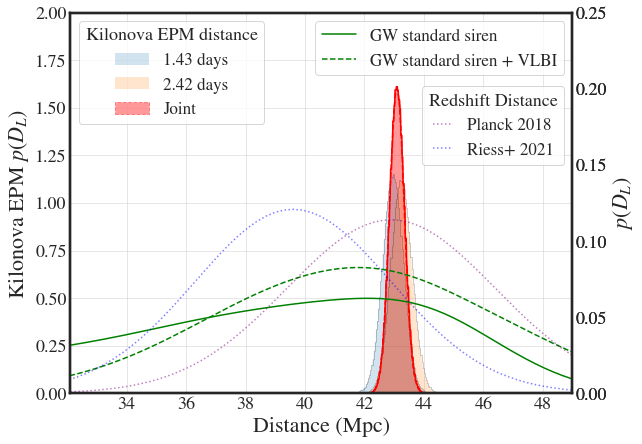

In [92]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]
n_days = [1.43, 2.42, 3.42, 4.40, 5.40]

mini = 35
maxi = 50

files = ["./data/OB1/OB1_3_peaks_with_gaussian_2.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_filtered_3.pkl", "./Data/OB4/OB4_3_peaks_filtered.pkl", 
         "./Data/OB5/OB5_3_filtered_short.pkl" ] 
files = ["./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_filtered_3.pkl", "./Data/OB4/OB4_3_peaks_filtered.pkl", 
         "./Data/OB5/OB5_3_peaks_with_gaussian.pkl" ] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
fig,ax = plt.subplots(figsize=(9,7))
    
steady = [22*1500, 25*100, 22*1000, 22*100, 22*3000]

d_m, ds_1, ds_2 = [], [], []
multi = [0.015, 0.015, 0, 0]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []

titles = ['1.43 days', '2.42 days', 'Joint']
for idx, file in enumerate(files[:2]):
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['T'])
    #print(emcee_res.params['vphot'])
    
    vphot = np.array(emcee_flatten['vphot'])#*np.random.uniform(low=1.422, high=1.438, size=len(emcee_flatten['vphot']))/1.43
    print(np.median(vphot))
    #*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['vphot']))
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])), 
                      vphot, n_days=n_days[idx])[steady[idx]:]
    #dl = dl
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h1 = plt.hist(dl, bins=400, histtype='stepfilled', density=True,
                 label=titles[idx], range=(mini,maxi), alpha=0.2)
    h1 = plt.hist(dl, bins=400, histtype='step', density=True,
                 range=(mini,maxi), color='k', alpha=0.2)
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h1[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    print(emcee_res.params['ve'])
    print(np.median(emcee_flatten['N']))

#fig,ax = plt.subplots(figsize=(8,8))

d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.xlabel(r'Distance (Mpc)'), plt.ylabel(r'Kilonova EPM $p(D_L)$') 
#plt.xlim(35, 47)
plt.xlim(41.6, 44.6)

mini = 35
maxi = 50

p1,p2 = pdf_list
dh = h1[1][1]-h1[1][0]
#plt.plot(h[1][1:], p1*p2/np.sum(p1*p2*dh))
ax.plot(np.linspace(mini, maxi, 1000), 
         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(mini+0.1, maxi-0.1, 1000))
         , color='red', alpha=1 )
ax.fill_between(np.linspace(mini, maxi, 1000), 
         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(mini+0.1, maxi-0.1, 1000)), 
                 color='red', ls='--', alpha=0.4, label=titles[2] )

sig1 = abs(ds_1+ds_2)/2
sigma = np.sum(1/sig1**2)**(-1/2)
mu = np.sum(1/sig1**2/np.sum(1/sig1**2)*d_m)
combined = 1/np.sqrt(2*np.pi*sigma**2)*np.exp( -(np.linspace(41, 44, 100)-mu)**2/(2*sigma**2))
plt.plot( np.linspace(41, 44, 100), 
         combined, color='red', ls='--', alpha=1)
#plt.fill_between( np.linspace(42.9, 44, 100), 
#         combined, color='red', ls='--', alpha=0.2, label='Epoch 1+2')
plt.legend(frameon=True, fontsize=17, loc=2,  title="Kilonova EPM distance")
y_max = 2; ax.set_ylim(0,y_max)





ax2 = ax.twinx(); lines = []
lines += ax2.plot(dists, d_theta_jn*np.sum(gw_Z, axis=1), label='GW standard siren', ls='-', color='green')
lines += ax2.plot(dists, y/norm, label='GW standard siren + VLBI', ls='--', color='green')
ax2.set_ylim(0,y_max/8); plt.grid(False); plt.xlim(32.1, 49)
ax2.ticklabel_format(style='plain');ax.ticklabel_format(style='plain'); plt.ylabel(r'$p(D_L)$')#"", color='green')


#plt.plot(dists, 1/np.sqrt(2*np.pi*3.1**2)*np.exp(-(41-dists)**2/(2*3.1**2)), label='Hjorth (2017)', ls='dotted', color='purple')
#plt.plot(dists, 1/np.sqrt(2*np.pi*2.3**2)*np.exp(-(40.7-dists)**2/(2*2.3**2)), label='Cantiello (2018)', ls='dotted', color='red')
#40.7 ± 1.4 ± 1.9
plt.legend(lines, ['GW standard siren', 'GW standard siren + VLBI'], frameon=True, fontsize=17, loc=1)#(0.02, 0.55))

#plt.fill
lines2 = []
ax3 = ax.twinx(); 
ax3.set_ylim(0,y_max/8); ax3.ticklabel_format(style='plain'); ax3.grid(False)
lines2 += ax3.plot(dists, 1/np.sqrt(2*np.pi*3.5**2)*np.exp(-(42.9-dists)**2/(2*3.5**2)), label='Redshift distance (Planck 2018)', 
         ls='dotted', color='purple', alpha=0.5)
lines2 += ax3.plot(dists, 1/np.sqrt(2*np.pi*3.3**2)*np.exp(-(39.6-dists)**2/(2*3.3**2)), label='Redshift distance (Riess+ 2021)', 
         ls='dotted', color='blue'  , alpha=0.5)

#H0_p = 42.9; dH0_p = 0.35
#plt.fill_between([H0_p-dH0_p, H0_p+dH0_p], [0, 0], [2, 2], color='blue', alpha=0.2, label='Planck 2018' )

#H0_s = 39.6; dH0_s = 0.6
#plt.fill_between([H0_s-dH0_s, H0_s+dH0_s], [0, 0], [2, 2], color='green', alpha=0.2, label='SHOES 2021' )

plt.rcParams['legend.title_fontsize'] = 18
plt.legend(lines2, ['Planck 2018','Riess+ 2021'], frameon=True, fontsize=17, 
          loc = (0.7,0.6), #for left loc=(0.02,0.485), 
          title = 'Redshift Distance', handlelength=1.2)

#plt.savefig('Pictures/dl_dist_15.png', dpi=300)


In [93]:
mu, sigma

(43.09303658422208, 0.2488147767900994)

0.27730872745343155 0.27793590677592556
Occult= 0.011108657158602665
Lum_dist =  42.95579478771063 + 0.34729115191076687 - 0.34827673264786085
<Parameter 've', value=0.08640330243076558 +/- 0.00664, bounds=[0:1]>
1.3338150746859284e-29
0.24701604398726743 0.24759563525437875
Occult= 1.4727446008300493
Lum_dist =  43.23611945837973 + 0.3604962332522845 - 0.35300134713390463
<Parameter 've', value=0.780007595922463 +/- 0.171, bounds=[0:1]>
2.752046990957482e-29
0.20376243940232913 0.20397601390780323
Occult= 3.5282757368413553
Lum_dist =  40.236483726292576 + 0.3527497078174022 - 0.3447094599740126
<Parameter 've', value=6.626496794247202 +/- 2.32, bounds=[0:10]>
3.817335296521477e-29
0.1723608324355996 0.17304530867385287
Occult= 7.656267982349197
Lum_dist =  45.92453339981485 + 0.46257695120241493 - 0.4539718128641894
<Parameter 've', value=7.104226961196531 +/- 3.54, bounds=[0:10]>
3.2010461509524127e-29
0.148588547415522 0.1487510652639866
Occult= 19.885019152196143
Lum_dist =  43.92

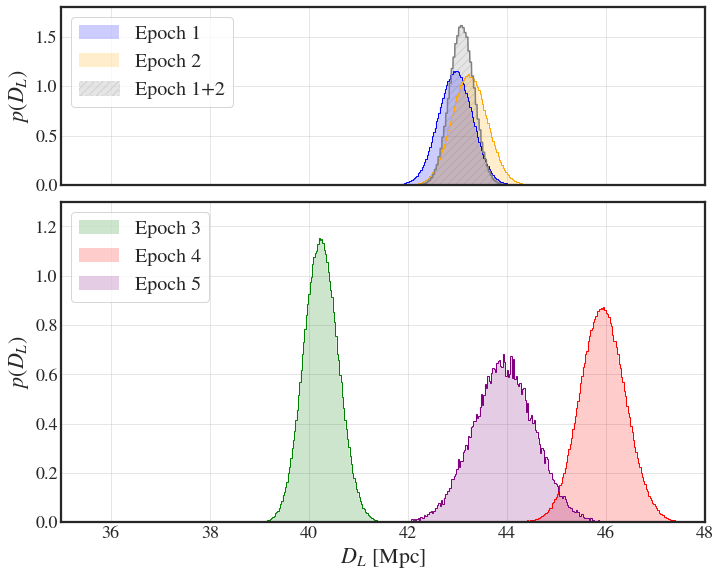

In [95]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]


n_days = [1.43, 2.42, 3.42, 4.40, 5.40]

files = ["./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_filtered_3.pkl", "./Data/OB4/OB4_3_peaks_filtered.pkl", 
         "./Data/OB5/OB5_3_filtered_short.pkl" ] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
fig,ax = plt.subplots(figsize=(10,8), nrows=2, sharex=True, gridspec_kw={
                           'height_ratios': [1, 1.8]})
    
steady = [22*1500, 25*100, 22*1000, 22*100, 22*3000]

d_m, ds_1, ds_2 = [], [], []
multi_1=np.array([1, 1, 1, 1, 1])
multi = [0.015, 0.015, 0.017, 0.017, 0.025]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
color_list = ['blue', 'orange', 'green', 'red', 'purple']
hatch_list = ['///', None, None, None, None]#multi = np.ones(5) 

#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []
x=0
for idx, file in enumerate(files):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['T'])
    #print(emcee_res.params['vphot'])
    
    vphot = np.array(emcee_flatten['vphot'])
    print(np.percentile(vphot, 16.9),np.median(vphot))
    print('Occult=',np.median(np.array(emcee_flatten['occult'])))
    #*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['vphot']))
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = ax[x].hist(dl, bins=500, histtype='step', density=True, range=(37,50), color=color_list[idx])
    h = ax[x].hist(dl, bins=500, histtype='stepfilled', alpha=0.2,
                 density=True, label='Epoch '+str(idx+1), range=(37,50), color=color_list[idx])
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    print(emcee_res.params['ve'])
    print(np.median(emcee_flatten['N']))

ax[0].plot(np.linspace(40, 44.5, 1000), 
         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(40, 44.5, 1000))
         , color='grey', alpha=1 )
ax[0].fill_between(np.linspace(40, 44.5, 1000), 
         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(40, 44.5, 1000)), 
                 color='grey', ls='--', alpha=0.2, label='Epoch 1+2', hatch='///' )

    
d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.legend(frameon=True, fontsize=20, loc=2), ax[0].legend(frameon=True, fontsize=20, loc=2)
plt.xlabel(r'$D_L$ [Mpc]'), plt.ylabel(r'$p(D_L)$'),  ax[0].set_ylabel(r'$p(D_L)$') 
plt.ylim(0, 1.3), ax[0].set_ylim(0, 1.8)

plt.xlim(35, 48)
fig.tight_layout(pad=0.3)

#plt.savefig('Pictures/dl_dist_5_3.png', dpi=300)

In [224]:
files = ["./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_with_gaussian.pkl", "./Data/OB4/OB4_3_peaks_with_gaussian.pkl", 
         "./Data/OB5/OB5_3_peaks_with_gaussian_2.pkl" ] 
for idx, file in enumerate(files):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['cen1'])
    print(emcee_res.params['cen2']*1e9)

1922.8052277798638
1900.2850656969606
1978.3368854343569
2005.8705163306313
2028.336323287845


Lum_dist =  42.947873230962756 + 0.3494512753134984 - 0.3550997549651953
Lum_dist =  43.23773068729962 + 0.35846910651581965 - 0.35367882945914175
Lum_dist =  41.162690079140965 + 0.36818596947627924 - 0.373540029205941
Lum_dist =  46.259638735762536 + 0.509047186294076 - 0.497434244293089
Lum_dist =  43.282555360997556 + 0.8941396720308958 - 0.9093460405014966
Lum_dist =  44.44176715187889 + 0.3967260105073578 - 0.38769822809411636
Lum_dist =  42.51988375938005 + 0.33317602729598406 - 0.32767605431320845
Lum_dist =  35.877877873460825 + 0.7099892358405384 - 1.721378707258495
Lum_dist =  44.22655933948239 + 0.4911372419251805 - 0.4756883235708642
Lum_dist =  45.87241727716391 + 0.8415033697586907 - 0.8038990954774476


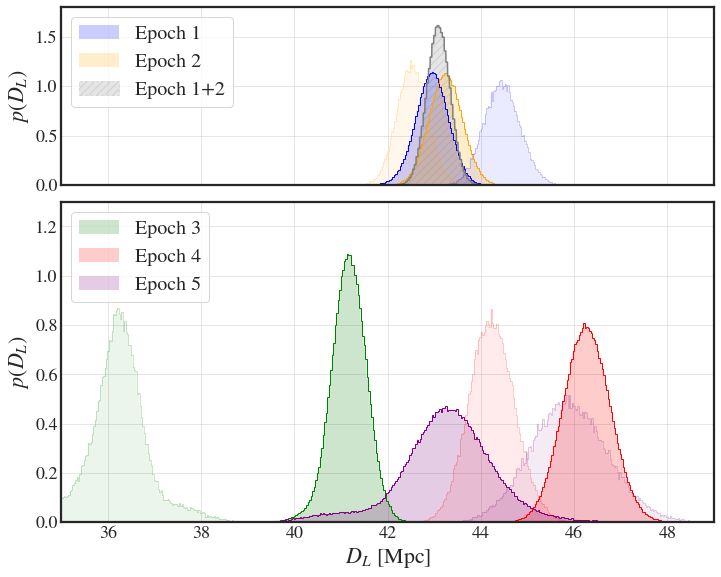

In [137]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]


n_days = [1.43, 2.42, 3.42, 4.40, 5.40]

files = ["./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_with_gaussian.pkl", "./Data/OB4/OB4_3_peaks_with_gaussian.pkl", 
         "./Data/OB5/OB5_3_peaks_with_gaussian_2.pkl" ] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
fig,ax = plt.subplots(figsize=(10,8), nrows=2, sharex=True, gridspec_kw={
                           'height_ratios': [1, 1.8]})
    
steady = [22*1000, 25*1500, 22*1000, 22*100, 22*1000]

d_m, ds_1, ds_2 = [], [], []
multi_1=np.array([1, 1, 1, 1, 1])
multi = [0.015, 0.015, 0.017, 0.02, 0.035]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
color_list = ['blue', 'orange', 'green', 'red', 'purple']
hatch_list = ['///', None, None, None, None]#multi = np.ones(5) 

#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []
x=0
for idx, file in enumerate(files):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['T'])
    #print(emcee_res.params['vphot'])
    
    vphot = np.array(emcee_flatten['vphot'])
    #print(np.percentile(vphot, 16.9),np.median(vphot))
    #print('Occult=',np.median(np.array(emcee_flatten['occult'])))
    #*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['vphot']))
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = ax[x].hist(dl, bins=400, histtype='step', density=True, range=(37,50), color=color_list[idx])
    h = ax[x].hist(dl, bins=400, histtype='stepfilled', alpha=0.2,
                 density=True, label='Epoch '+str(idx+1), range=(37,50), color=color_list[idx])
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    #print(emcee_res.params['ve'])
    #print(np.median(emcee_flatten['N']))

ax[0].plot(np.linspace(40, 44.5, 1000), 
         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(40, 44.5, 1000))
         , color='grey', alpha=1 )
ax[0].fill_between(np.linspace(40, 44.5, 1000), 
         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(40, 44.5, 1000)), 
                 color='grey', ls='--', alpha=0.2, label='Epoch 1+2', hatch='///' )

    
d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.legend(frameon=True, fontsize=20, loc=2), ax[0].legend(frameon=True, fontsize=20, loc=2)
plt.xlabel(r'$D_L$ [Mpc]'), plt.ylabel(r'$p(D_L)$'),  ax[0].set_ylabel(r'$p(D_L)$') 
plt.ylim(0, 1.3), ax[0].set_ylim(0, 1.8)

plt.xlim(35, 48)
fig.tight_layout(pad=0.3)


files = ["./data/OB1/OB1_3_peaks_no_gaussian_2.pkl", "./data/OB2/OB2_3_peaks_no_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_no_gaussian.pkl", "./Data/OB4/OB4_3_peaks_no_gaussian.pkl", 
         "./Data/OB5/OB5_3_peaks_no_gaussian.pkl" ] 

    
steady = [25*1000, 25*2000, 25*200, 22*1000, 22*2000]

d_m, ds_1, ds_2 = [], [], []
multi_1=np.array([1.0, 1, 1, 1, 1])
multi = [0.017, 0.015, 0.017, 0.02, 0.035]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
color_list = ['blue', 'orange', 'green', 'red', 'purple']
hatch_list = ['///', None, None, None, None]#multi = np.ones(5) 

#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []
x=0
for idx, file in enumerate(files[:5]):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    vphot = np.array(emcee_flatten['vphot'])
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = ax[x].hist(dl, bins=500, histtype='step', density=True, range=(35,50), color=color_list[idx], alpha=0.2)
    h = ax[x].hist(dl, bins=500, histtype='stepfilled', alpha=0.08,
                 density=True, range=(35,50), color=color_list[idx])
    temp.append( np.median(emcee_flatten['T']) )
    
    pdf_list.append(h[0])
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)


    
d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.legend(frameon=True, fontsize=20, loc=2), ax[0].legend(frameon=True, fontsize=20, loc=2)
plt.xlabel(r'$D_L$ [Mpc]'), plt.ylabel(r'$p(D_L)$'),  ax[0].set_ylabel(r'$p(D_L)$') 
plt.ylim(0, 1.3), ax[0].set_ylim(0, 1.8)

plt.xlim(35, 49)
fig.tight_layout(pad=0.3)
#plt.savefig('Pictures/dl_dist_5_5.png', dpi=300)

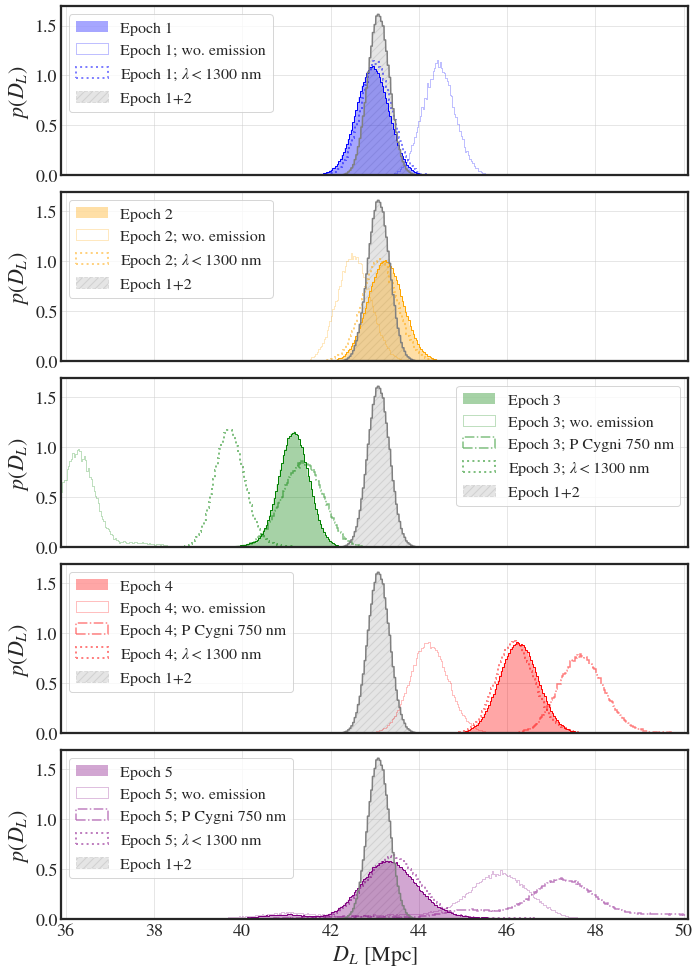

In [241]:
fig,ax = plt.subplots(figsize=(10,14), nrows=5, sharex=True)

files = ["./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_with_gaussian.pkl", "./Data/OB4/OB4_3_peaks_with_gaussian.pkl", 
         "./Data/OB5/OB5_3_peaks_with_gaussian_2.pkl" ] 

steady = [22*1000, 25*1500, 22*1000, 22*100, 22*1000]
#multi_1=np.array([0.96, 1, 0.94, 1.004, 1])
multi_1=np.array([1, 1, 1, 1, 1])  #flux calibration
multi = [0.015, 0.015, 0.017, 0.02, 0.025]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
multi = (0.015**2+np.array([0.005, 0.008, 0.005, 0.008, 0.022])**2)**(1/2)      #dust extinction + flux calibration
#multi = (0.015**2+np.array([0.025, 0.057, 0.044, 0.04, 0.06])**2)**(1/2)      

color_list = ['blue', 'orange', 'green', 'red', 'purple']
hatch_list = ['///', None, None, None, None]#multi = np.ones(5) 
x=0
for idx, file in enumerate(files):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    
    vphot = np.array(emcee_flatten['vphot'])  
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = ax[idx].hist(dl, bins=400, histtype='step', density=True, range=(37,51), color=color_list[idx])
    h = ax[idx].hist(dl, bins=400, histtype='stepfilled', alpha=0.35,
                 density=True, label='Epoch '+str(idx+1), range=(37,51), color=color_list[idx])    
    
    ax[idx].plot(np.linspace(40, 44.5, 1000), 
         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(40, 44.5, 1000))
         , color='grey', alpha=1 )
    ax[idx].fill_between(np.linspace(40, 44.5, 1000), 
         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(40, 44.5, 1000)), 
                 color='grey', ls='--', alpha=0.2, label='Epoch 1+2', hatch='///' )

    
files = ["./data/OB1/OB1_3_peaks_no_gaussian_2.pkl", "./data/OB2/OB2_3_peaks_no_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_no_gaussian.pkl", "./Data/OB4/OB4_3_peaks_no_gaussian.pkl", 
         "./Data/OB5/OB5_3_peaks_no_gaussian.pkl" ] 

    


for idx, file in enumerate(files[:5]):
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    vphot = np.array(emcee_flatten['vphot'])
       
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = ax[idx].hist(dl, bins=500, histtype='step', density=True, range=(35,51), color=color_list[idx], alpha=0.5, #hatch='\\\\', edgecolor=color_list[idx], 
                    label='Epoch '+str(idx+1)+'; wo. emission', linestyle=(0, (1, 1)), linewidth=1)
    #h = ax[idx].hist(dl, bins=500, histtype='stepfilled', alpha=0.05,
    #             density=True, range=(35,51), color=color_list[idx])

#files = ["./data/OB1/OB1_3_peaks_100walkers.pkl", "./data/OB2/OB2_3_peaks_100walkers.pkl", 
#         "./data/OB3/OB3_3_peaks_filtered_3.pkl", "./Data/OB4/OB4_3_peaks_filtered.pkl", 
#         "./Data/OB5/OB5_3_filtered_short.pkl" ] 
#steady = [22*100, 25*100, 22*1000, 22*100, 22*3000]

#for idx, file in enumerate(files):
#    pickle_in = open(file,"rb"); emcee_res = pickle.load(pickle_in)
#    emcee_flatten = emcee_res.flatchain
    
#    vphot = np.array(emcee_flatten['vphot'])
        
#    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
#                      vphot, n_days=n_days[idx])[steady[idx]:]
    
#    h = ax[idx].hist(dl, bins=500, histtype='step', density=True, range=(35,51), color=color_list[idx], alpha=0.5,  
#                    label='Epoch '+str(idx+1)+'; fixed emission', linestyle=(0, (5, 2)), linewidth=2 )#, #hatch="X", edgecolor=color_list[idx])
    #h = ax[idx].hist(dl, bins=500, histtype='stepfilled', alpha=0.05, 
    #             density=True, range=(35,51), color=color_list[idx])


files = ["./Data/OB3/OB3_two_Pcygni_40x2000.pkl", "./Data/OB4/OB4_two_Pcygni_28x5000.pkl" , "./Data/OB5/OB5_two_Pcygni_28x10000_lambda0_7500.pkl"] 

steady = [22*100, 25*100, 22*1000, 28*500, 28*1000]

d_m, ds_1, ds_2 = [], [], []
for idx, file in enumerate(files):
    idx = idx+2
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    vphot = np.array(emcee_flatten['vphot'])
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, n_days=n_days[idx])[steady[idx]:]
    
    h = ax[idx].hist(dl, bins=500, histtype='step', density=True, range=(37,51), color=color_list[idx], alpha=0.5, #hatch='//', edgecolor=color_list[idx], 
                     label='Epoch '+str(idx+1)+'; P Cygni 750 nm', linestyle='dashdot', linewidth=1.5)
    
    #h = ax[idx].hist(dl, bins=500, histtype='stepfilled', alpha=0.05, hatch='//', edgecolor=color_list[idx],
    #             density=True, range=(37,51), color=color_list[idx])
    
    
files = ["./Data/OB1/OB1_3_peaks_lambda_13000.pkl", "./Data/OB2/OB2_3_peaks_lambda_13000.pkl", 
         "./Data/OB3/OB3_3_peaks_lambda_13000_3.pkl", "./Data/OB4/OB4_3_peaks_lambda_13000_1.pkl",
         "./Data/OB5/OB5_3_peaks_lambda_13000_1.pkl" ] 


steady = [22*1000, 25*1500, 22*1000, 22*100, 22*1000]
color_list = ['blue', 'orange', 'green', 'red', 'purple']
x=0
for idx, file in enumerate(files):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    
    vphot = np.array(emcee_flatten['vphot'])  
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = ax[idx].hist(dl, bins=400, histtype='step', density=True, range=(37,51), color=color_list[idx], 
                     label=r'Epoch '+str(idx+1)+'; $\lambda < 1300$ nm', alpha=0.5, linestyle='dotted', linewidth=2)
    #, hatch='--', edgecolor=color_list[idx])
    #h = ax[idx].hist(dl, bins=400, histtype='stepfilled', alpha=0.05,
    #             density=True, range=(37,51), color=color_list[idx])    


    

plt.xlabel(r'$D_L$ [Mpc]')
ax[0].set_ylabel(r'$p(D_L)$'),  ax[1].set_ylabel(r'$p(D_L)$'),  
ax[2].set_ylabel(r'$p(D_L)$'),  ax[3].set_ylabel(r'$p(D_L)$'),  ax[4].set_ylabel(r'$p(D_L)$') 
plt.xlim(35.9 ,50.1)
ax[0].legend(frameon=True, fontsize=16, loc=2)
ax[1].legend(frameon=True, fontsize=16, loc=2)
ax[2].legend(frameon=True, fontsize=16, loc=1)
ax[3].legend(frameon=True, fontsize=16, loc=2)
ax[4].legend(frameon=True, fontsize=16, loc=2)

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)

#plt.savefig('Pictures/d_l_Constraints_flux_calibrated.png', dpi=300)


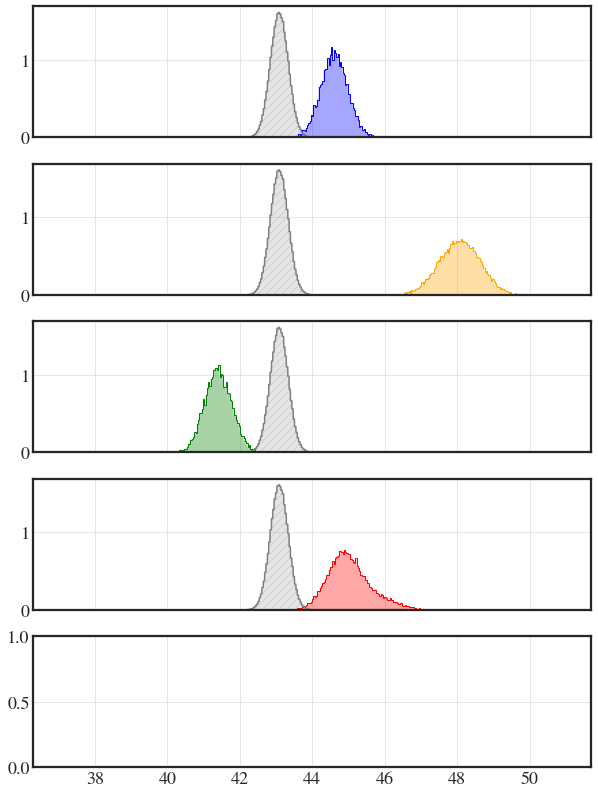

In [244]:
fig,ax = plt.subplots(figsize=(10,14), nrows=5, sharex=True)

files = ["./data/OB1/OB1_No_UV.pkl", "./Data/OB2/OB2_No_UV.pkl", "./Data/OB3/OB3_No_UV.pkl", 
         "./Data/OB4/OB4_No_UV.pkl"] 

steady = [22*1000, 25*1500, 22*1000, 22*100, 22*1000]
#multi_1=np.array([0.96, 1, 0.94, 1.004, 1])
multi_1=np.array([1, 1, 1, 1, 1])  #flux calibration
multi = [0.015, 0.015, 0.017, 0.02, 0.025]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
multi = (0.015**2+np.array([0.005, 0.008, 0.005, 0.008, 0.022])**2)**(1/2)      #dust extinction + flux calibration
#multi = (0.015**2+np.array([0.025, 0.057, 0.044, 0.04, 0.06])**2)**(1/2)      

color_list = ['blue', 'orange', 'green', 'red', 'purple']
hatch_list = ['///', None, None, None, None]#multi = np.ones(5) 
x=0
for idx, file in enumerate(files):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    
    vphot = np.array(emcee_flatten['vphot'])  
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = ax[idx].hist(dl, bins=400, histtype='step', density=True, range=(37,51), color=color_list[idx])
    h = ax[idx].hist(dl, bins=400, histtype='stepfilled', alpha=0.35,
                 density=True, label='Epoch '+str(idx+1), range=(37,51), color=color_list[idx])    
    
    ax[idx].plot(np.linspace(40, 44.5, 1000), 
         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(40, 44.5, 1000))
         , color='grey', alpha=1 )
    ax[idx].fill_between(np.linspace(40, 44.5, 1000), 
         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(40, 44.5, 1000)), 
                 color='grey', ls='--', alpha=0.2, label='Epoch 1+2', hatch='///' )

    

In [162]:
files = ["./data/OB1/OB1_3_peaks_with_gaussian_3.pkl", "./data/OB2/OB2_3_peaks_with_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_with_gaussian.pkl", "./Data/OB4/OB4_3_peaks_with_gaussian.pkl", 
         "./Data/OB5/OB5_3_peaks_with_gaussian_2.pkl" ] 

steady = [22*1000, 25*1500, 22*1000, 22*100, 22*1000]
multi_1=np.array([1, 1, 1, 1, 1])
multi = [0.015, 0.015, 0.017, 0.02, 0.025]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
color_list = ['blue', 'orange', 'green', 'red', 'purple']
hatch_list = ['///', None, None, None, None]#multi = np.ones(5) 
x=0
for idx, file in enumerate(files):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    print(2.33*emcee_res.params['sig1']/emcee_res.params['cen1'])
    #print(2.33*emcee_res.params['sig2']/emcee_res.params['cen2'])

0.08577063415278689
0.10196429468603642
0.09553934146006715
0.10156639851320354
0.11548225309162513


0.2942799497645016 0.29464847488309165
Occult= 0.00025151236393796403
Lum_dist =  44.77773587261866 + 0.3447481686535667 - 0.3417419125090717
<Parameter 've', value=0.18672828162112243 +/- 0.082, bounds=[0:1]>
1.444076557590604e-29
0.24025861817445457 0.26002790799264075
Occult= 0.2696330606899191
Lum_dist =  42.52112997068378 + 0.3352233429849605 - 0.33482023574428865
<Parameter 've', value=0.6749635109502433 +/- 0.204, bounds=[0:1]>
3.2553075463591537e-29
0.19937234809135101 0.2045115027316478
Occult= 4.527198497031755
Lum_dist =  35.68667019319929 + 0.8317691862074525 - 1.597688656368824
<Parameter 've', value=9.962164812949643 +/- 0.0786, bounds=[0:10]>
4.818268473376406e-29
0.197783564067167 0.19857862652200886
Occult= 19.236931213736266
Lum_dist =  44.27485401282466 + 0.5742456390257544 - 0.4550702092259158
<Parameter 've', value=9.899728597677559 +/- 0.119, bounds=[0:10]>
4.8779290110123244e-29
0.148588547415522 0.1487510652639866
Occult= 19.885019152196143
Lum_dist =  43.939560

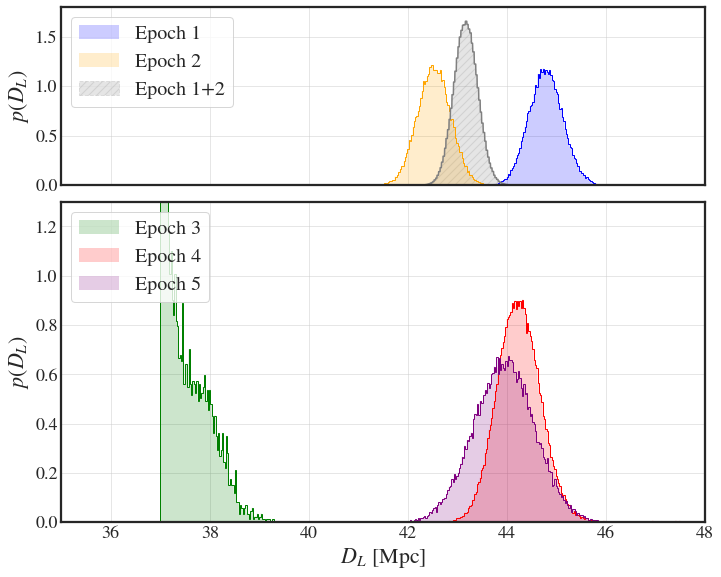

In [12]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]


n_days = [1.43, 2.42, 3.42, 4.40, 5.40]

files = ["./data/OB1/OB1_3_peaks_no_gaussian.pkl", "./data/OB2/OB2_3_peaks_no_gaussian_1.pkl", 
         "./data/OB3/OB3_3_peaks_no_gaussian.pkl", "./Data/OB4/OB4_3_peaks_no_gaussian.pkl", 
         "./Data/OB5/OB5_3_filtered_short.pkl" ] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
fig,ax = plt.subplots(figsize=(10,8), nrows=2, sharex=True, gridspec_kw={
                           'height_ratios': [1, 1.8]})
    
steady = [25*1000, 25*2000, 22*1000, 22*100, 22*3000]

d_m, ds_1, ds_2 = [], [], []
multi_1=np.array([1, 1, 1, 1, 1])
multi = [0.015, 0.015, 0.017, 0.017, 0.025]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
color_list = ['blue', 'orange', 'green', 'red', 'purple']
hatch_list = ['///', None, None, None, None]#multi = np.ones(5) 

#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []
x=0
for idx, file in enumerate(files):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['T'])
    #print(emcee_res.params['vphot'])
    
    vphot = np.array(emcee_flatten['vphot'])
    print(np.percentile(vphot, 16.9),np.median(vphot))
    print('Occult=',np.median(np.array(emcee_flatten['occult'])))
    #*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['vphot']))
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = ax[x].hist(dl, bins=500, histtype='step', density=True, range=(37,50), color=color_list[idx])
    h = ax[x].hist(dl, bins=500, histtype='stepfilled', alpha=0.2,
                 density=True, label='Epoch '+str(idx+1), range=(37,50), color=color_list[idx])
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    print(emcee_res.params['ve'])
    print(np.median(emcee_flatten['N']))

ax[0].plot(np.linspace(40, 44.5, 1000), 
         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(40, 44.5, 1000))
         , color='grey', alpha=1 )
ax[0].fill_between(np.linspace(40, 44.5, 1000), 
         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(40, 44.5, 1000)), 
                 color='grey', ls='--', alpha=0.2, label='Epoch 1+2', hatch='///' )

    
d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.legend(frameon=True, fontsize=20, loc=2), ax[0].legend(frameon=True, fontsize=20, loc=2)
plt.xlabel(r'$D_L$ [Mpc]'), plt.ylabel(r'$p(D_L)$'),  ax[0].set_ylabel(r'$p(D_L)$') 
plt.ylim(0, 1.3), ax[0].set_ylim(0, 1.8)

plt.xlim(35, 48)
fig.tight_layout(pad=0.3)

#plt.savefig('Pictures/dl_dist_5_3.png', dpi=300)

0.27954092652954726 0.2798932114605146
Occult= 0.038394064353415844
Lum_dist =  43.28585303026949 + 0.33596754225263936 - 0.33028120065684163
<Parameter 've', value=0.3127667868694095 +/- 0.0467, bounds=[0:1]>
1.3391756106371648e-29
0.24763280570541202 0.24808001429652052
Occult= 1.3053866710215676
Lum_dist =  43.04850571926194 + 0.35291417730654473 - 0.34592861696818034
<Parameter 've', value=0.7257080469406663 +/- 0.182, bounds=[0:1]>
2.791868985489651e-29
0.20376243940232913 0.20397601390780323
Occult= 3.5282757368413553
Lum_dist =  40.235876148380044 + 0.35340950951491834 - 0.34353544096013167
<Parameter 've', value=6.626496794247202 +/- 2.32, bounds=[0:10]>
3.817335296521477e-29
0.1723608324355996 0.17304530867385287
Occult= 7.656267982349197
Lum_dist =  45.923736496038465 + 0.46257597032192166 - 0.4525347351984266
<Parameter 've', value=7.104226961196531 +/- 3.54, bounds=[0:10]>
3.2010461509524127e-29
0.148588547415522 0.1487510652639866
Occult= 19.885019152196143
Lum_dist =  43.

(34.5, 48.2)

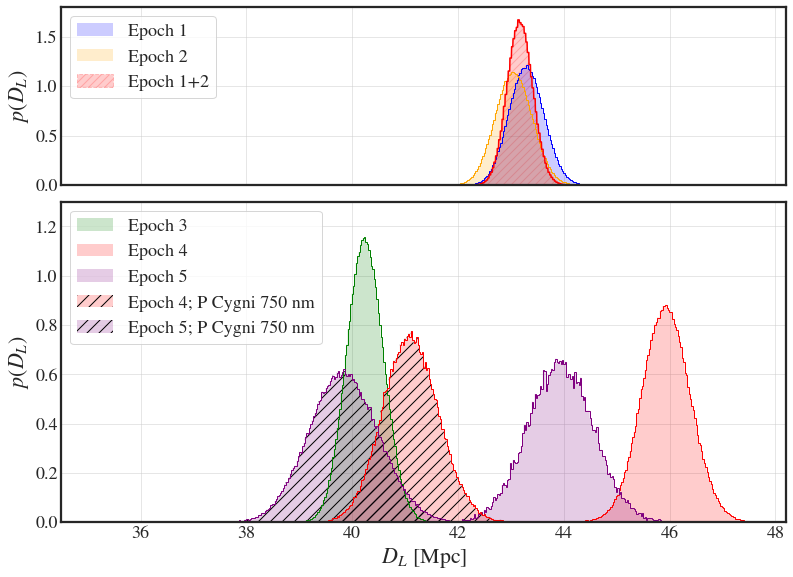

In [100]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]


n_days = [1.43, 2.42, 3.42, 4.40, 5.40]

files = ["./data/OB1/OB1_3_peaks_100walkers.pkl", "./data/OB2/OB2_3_peaks_100walkers.pkl", 
         "./data/OB3/OB3_3_peaks_filtered_3.pkl", "./Data/OB4/OB4_3_peaks_filtered.pkl", 
         "./Data/OB5/OB5_3_filtered_short.pkl" ] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
fig,ax = plt.subplots(figsize=(11,8), nrows=2, sharex=True, gridspec_kw={
                           'height_ratios': [1, 1.8]})
    
steady = [22*100, 25*100, 22*1000, 22*100, 22*3000]

d_m, ds_1, ds_2 = [], [], []
multi_1=np.array([1, 1, 1, 1, 1])
multi = [0.015, 0.015, 0.017, 0.017, 0.025]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
color_list = ['blue', 'orange', 'green', 'red', 'purple']
hatch_list = ['///', None, None, None, None]#multi = np.ones(5) 

#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []
x=0
for idx, file in enumerate(files):
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['T'])
    #print(emcee_res.params['vphot'])
    
    vphot = np.array(emcee_flatten['vphot'])
    print(np.percentile(vphot, 16.9),np.median(vphot))
    print('Occult=',np.median(np.array(emcee_flatten['occult'])))
    #*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['vphot']))
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = ax[x].hist(dl, bins=500, histtype='step', density=True, range=(37,50), color=color_list[idx])
    h = ax[x].hist(dl, bins=500, histtype='stepfilled', alpha=0.2,
                 density=True, label='Epoch '+str(idx+1), range=(37,50), color=color_list[idx])
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    print(emcee_res.params['ve'])
    print(np.median(emcee_flatten['N']))

ax[0].plot(np.linspace(40, 44.5, 1000), 
         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(40, 44.5, 1000))
         , color='red', alpha=1 )
ax[0].fill_between(np.linspace(40, 44.5, 1000), 
         interp1d( (h1[1][1:]+h1[1][:-1])/2, p1*p2/np.sum(p1*p2*dh), kind='nearest')(np.linspace(40, 44.5, 1000)), 
                 color='red', ls='--', alpha=0.2, label='Epoch 1+2', hatch='///' )

    
d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
plt.xlabel(r'$D_L$ [Mpc]'), plt.ylabel(r'$p(D_L)$'),  ax[0].set_ylabel(r'$p(D_L)$') 
plt.ylim(0, 1.3), ax[0].set_ylim(0, 1.8)

fig.tight_layout(pad=0.3)


files = ["./Data/OB4/OB4_two_Pcygni_28x5000.pkl" , "./Data/OB5/OB5_two_Pcygni_28x10000_lambda0_7500.pkl"] 
#files = ["./Data/OB4/OB4_two_Pcygni_28x5000_lambda0_7550.pkl" , "./Data/OB5/OB5_two_Pcygni_28x5000_lambda0_7550.pkl"]

#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 
steady = [22*100, 25*100, 22*1000, 28*500, 28*1500]

d_m, ds_1, ds_2 = [], [], []
multi_1=np.array([1, 1, 1, 1, 1])
multi = [0.015, 0.015, 0.017, 0.017, 0.025]#¤, 0.05, 0.05, 0.05]#np.ones(5) 
color_list = ['blue', 'orange', 'green', 'red', 'purple']
#multi = np.ones(5) 

#scale = [0, 0, 0.02, 0.02, 0.02]
#multi = [np.sqrt(1/1.01), np.sqrt(1/1.01), np.sqrt(1/0.94), 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]
temp = []
pdf_list = []
for idx, file in enumerate(files):
    idx = idx+3
    if idx>1: 
        x=1
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    #print(emcee_res.params['T'])
    #print(emcee_res.params['vphot'])
    
    vphot = np.array(emcee_flatten['v_phot_n'])
    print(np.percentile(vphot, 16.9),np.median(vphot))
    print('Occult=',np.median(np.array(emcee_flatten['occult'])))
    #*np.random.normal(loc=1, scale=scale[idx], size=len(emcee_flatten['vphot']))
        
    dl = lum_dist_arr(np.array(emcee_flatten['N'])*multi_1[idx]*np.random.normal(loc=1, scale=multi[idx], size=len(emcee_flatten['N'])),
                      vphot, n_days=n_days[idx])[steady[idx]:]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = ax[x].hist(dl, bins=500, histtype='step', density=True, range=(37,50), color=color_list[idx])
    h = ax[x].hist(dl, bins=500, histtype='stepfilled', alpha=0.2, hatch='//',
                 density=True, label='Epoch '+str(idx+1)+'; P Cygni 750 nm', range=(37,50), color=color_list[idx])
    temp.append( np.median(emcee_flatten['T']) )
    
    #h = plt.hist(dl, bins=300, histtype='stepfilled', density=True, alpha=0.2, range=(37,47))
    pdf_list.append(h[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    print(emcee_res.params['ve'])
    print(np.median(emcee_flatten['N']))

d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
plt.legend(frameon=True, fontsize=18, loc=2), ax[0].legend(frameon=True, fontsize=18, loc=2)
plt.xlim(34.5, 48.2)

#plt.ticklabel_format(axis="y", style="plain", scilimits=(0,0))
#plt.savefig('Pictures/dl_dist_750_PCygni.png', dpi=300)

#plt.savefig('Pictures/dl_dist_5_4.png', dpi=300)

In [9]:
d_m[2:], sig1[2:]

(array([40.23507986, 45.9241152 , 44.02452099]),
 array([0.07196477, 0.23431636, 0.3144125 ]))

In [14]:
sig1 = abs(ds_1+ds_2)/2
sig1 = 0.2*np.ones_like(d_m)
sigma = np.sum(1/sig1[2:]**2)**(-1/2)
mu = np.sum(1/sig1[2:]**2/np.sum(1/sig1[2:]**2)*d_m[2:])
mu, np.std(d_m[2:])/np.sqrt(3)

(43.39457201830943, 1.365357710359472)

In [166]:
(40.23507986364028+45.924115200824545+44.02452099046347)/3

43.39457201830944

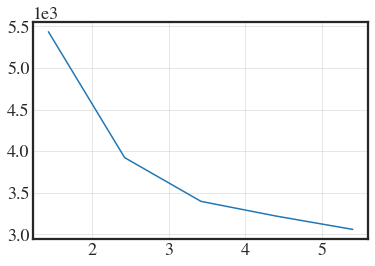

In [205]:
plt.plot(n_days, temp)


In [67]:
d_m,
d_rel = ((ds_2-ds_1)/d_m+[0.004, 0.0084, 0.005, 0.007, 0.022])*d_m

H0 =  66.8123600963551 + 0.10865823995150947 - 0.1280203246117111
H0 =  67.35698459722099 + 0.2335721144802676 - 0.15964164775226664
H0 =  71.87804135971074 + 0.12715831402084632 - 0.129954096275398
H0 =  62.97385854693788 + 0.32715011302474295 - 0.3155681955017897
H0 =  65.69108918133294 + 0.7196408256167217 - 0.22567917909198343


(Text(0, 0.5, 'p($H_0$)'), Text(0.5, 0, '$H_0$'))

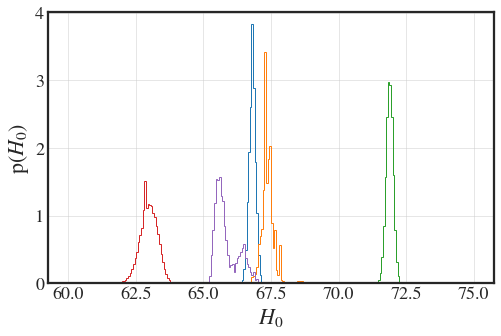

In [68]:
plt.figure(figsize=(8,5))

h_m, h_1, h_2 = [], [], []
for idx, file in enumerate(files):
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    vphot = np.array(emcee_flatten['vphot'])
    dl = lum_dist_arr(np.array(emcee_flatten['N']), vphot, n_days=n_days[idx])[steady[idx]:]*multi[idx]
    
    H0 = 0.00957*c*1e-3/dl * (1+1.53/2*0.00957) #0.00980*c*1e-3/dl
    
    plt.hist(H0, bins=250, range=(60,75), histtype='step', label='Epoch '+str(idx), density=True)
    d1, d_l, d_h = np.median(H0), np.percentile(H0,15.9), np.percentile(H0,100-15.9)
    h_m.append(d1); h_1.append(d1-d_l), h_2.append(d_h-d1)
    print('H0 = ', d1, '+', d_h-d1, '-', d1-d_l)
    
    
plt.ylabel('p($H_0$)'), plt.xlabel(r'$H_0$')


#plt.savefig('Pictures/H0_dist.png', dpi=300)

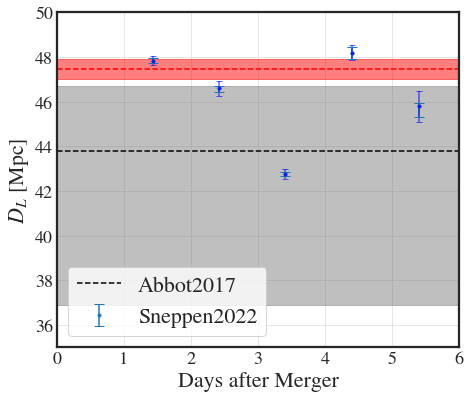

In [29]:
plt.figure(figsize=(7,6))
plt.errorbar([1.43, 2.42, 3.41, 4.4, 5.4], d_m, yerr = [ds_1,ds_2], 
             fmt='.', capsize=5, label='Sneppen2022')
plt.errorbar([1.43, 2.42, 3.41, 4.4, 5.4], d_m, yerr = d_rel, 
             fmt='.', color='blue', capsize=3, alpha=0.6)#, label='Sneppen2022')

plt.axhline(43.8, ls='--', color='k', label='Abbot2017')
plt.fill_between(np.arange(0,7), (36.9)*np.ones(7), (46.7)*np.ones(7), 
                 color='grey', alpha = 0.5)
dd = ds_2+ds_1#[d1high-d1low,d2high-d2low,d3high-d3low,d4high-d4low]
d_weight = np.sum( d_m[:2]*1/np.array(dd[:2])**2/np.sum(1/np.array(dd[:2])**2) )
d_unc = np.std(d_m[:2])/np.sqrt(2)
plt.axhline(d_weight, ls='--', color='red')
plt.fill_between(np.arange(0,10), (d_weight-d_unc)*np.ones(10), (d_weight+d_unc)*np.ones(10), 
                 color='red', alpha = 0.5)

plt.ylim(35,50), plt.xlim(0,6), plt.legend(frameon=True)
plt.xlabel('Days after Merger'), plt.ylabel(r'$D_L$ [Mpc]')
plt.tight_layout()

#plt.savefig('Pictures/Inferred_Sneppen_6.png', dpi=300)

In [16]:
#Muharjakee
d_best = 36.83
ddbest = 0.17

H0 = 0.00957*3e8*(10**(-3))/d_best * (1+1.53/2*0.00957)
dH0 = ((0.00957*c*(10**(-3))/d_best**2*ddbest)**2 + (0.000433*c*(10**(-3))/d_best)**2 )**(1/2)
H0, dH0 

(78.52345192913386, 3.545322056700937)

In [17]:
(0.000433**2+0.00018**2)**(1/2)

0.00046892323465573765

In [18]:
360/299792.458, (130)/299792.458

(0.0012008307427133474, 0.00043363332375759766)

In [19]:
(2924+307-360)/299792.458, 130/299792.458

(0.009576625173138946, 0.00043363332375759766)

In [163]:
#Muharjakee
d_best = 43.28
ddbest = 0.07

H0 = 0.00957*3e8*(10**(-3))/d_best * (1+1.53/2*0.00957)
dH0 = ((0.00957*c*(10**(-3))/d_best**2*ddbest)**2 + (0.000433*c*(10**(-3))/d_best)**2 )**(1/2)
H0, dH0 

(66.82113527148799, 3.0033033250607906)

In [6]:
H0_p,dH0_p  = 67.36, 0.54
#(H0_p-H0)/np.sqrt(dH0_p**2+dH0**2) 

In [7]:
H0_s,dH0_s  = 73.03, 1.04
#(H0_s-H0)/np.sqrt(dH0_s**2+dH0**2) 

In [34]:
(H0_p/H0)**(-1), (dH0_p**2+dH0**2)**(1/2)/H0

(0.9134844640894275, 0.04590665797959655)

In [35]:
(H0_s/H0)**(-1), (dH0_s**2+dH0**2)**(1/2)/H0

(0.8425621457081176, 0.04812558893765071)

In [19]:
dl = 0.00957*3e8*(10**(-3))/H0_p * (1+1.53/2*0.00957)
dl0 = ((0.0098*c*(10**(-3))/H0_p**2*dH0_p)**2 + (0.00079*c*(10**(-3))/H0_p)**2 )**(1/2)
print((0.0098*c*(10**(-3))/H0_p**2*dH0_p))
dl, dl0

0.3498943528867475


(42.93376981220309, 3.535763678530662)

In [20]:
dl = 0.00957*3e8*(10**(-3))/H0_s * (1+1.53/2*0.00957)
dl0 = ((0.0098*c*(10**(-3))/H0_s**2*dH0_s)**2 + (0.00079*c*(10**(-3))/H0_s)**2 )**(1/2)
print((0.0098*c*(10**(-3))/H0_s**2*dH0_s))
dl, dl0

0.5732948869262272


(39.60042084828153, 3.2954909495742197)

In [21]:
(1+1.53/2*0.00957)

1.00732105

In [34]:
#Hjorth
d_best = 38.1
ddbest = 0.1

H0 = 0.0098*3e8*(10**(-3))/d_best * (1+1.53/2*0.0111)
dH0 = ((0.0098*c*(10**(-3))/d_best**2*ddbest)**2 + (0.00079*c*(10**(-3))/d_best)**2 )**(1/2)
H0, dH0 

(77.82060393700787, 6.22376873797102)

In [37]:
#Abbot
d_best = 38.1
ddbest = 0.1

H0 = 0.01006*3e8*(10**(-3))/d_best
dH0 = ((0.01006*c*(10**(-3))/d_best**2*ddbest)**2 + (0.00055*c*(10**(-3))/d_best)**2 )**(1/2)
H0, dH0


(79.21259842519684, 4.335696352954241)

In [184]:
np.array([3327-310,150])/299792458

array([1.00636288e-05, 5.00346143e-07])

(0.0, 6.0)

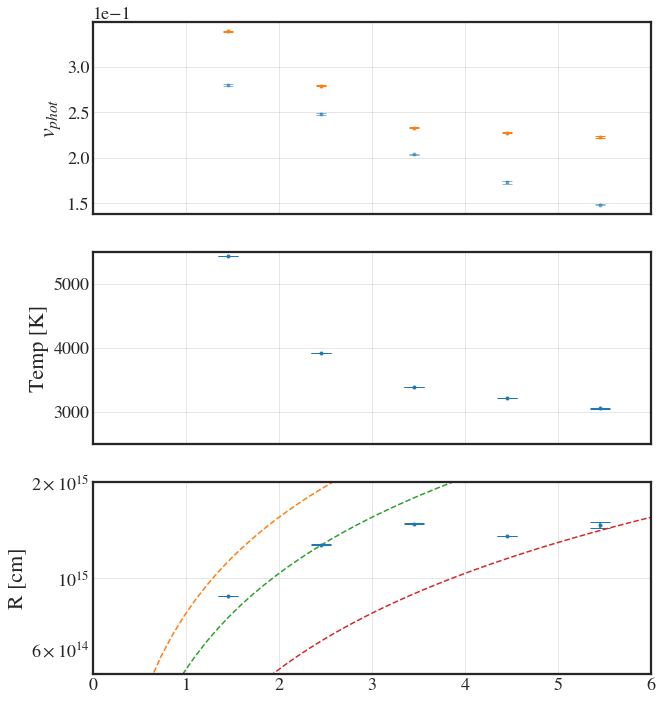

In [6]:
#files = ["./data/OB1/OB1_3_peaks_XL_2.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl",# "./Data/OB4/OB4_3_peaks_XL_2.pkl", 
#        "./Data/OB5/OB5_3_peaks_XL.pkl"] 
v_phot = []; dv_phot = []; v_max = []; dv_max = []
temp = []; dtemp = []; N = []; dN = []

n_days = [1.45, 2.45, 3.45, 4.45, 5.45]
for idx, file in enumerate(files):
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    v_phot.append(emcee_res.params['vphot'].value )
    dv_phot.append(emcee_res.params['vphot'].stderr)
    v_max.append(emcee_res.params['vmax'].value )
    dv_max.append(emcee_res.params['vmax'].stderr)
    
    temp.append(emcee_res.params['T'].value )
    dtemp.append(emcee_res.params['T'].stderr)
    N.append(emcee_res.params['N'].value )
    dN.append(emcee_res.params['N'].stderr)
    
fig,ax = plt.subplots(nrows=3, figsize=(10,12), sharex=True)
ax[0].errorbar(n_days, v_phot, yerr=2*np.array(dv_phot), fmt='.', capsize=5, alpha=0.5), ax[0].set_ylabel(r'$v_{phot}$')
ax[0].errorbar(n_days, v_max, yerr =2*np.array(dv_max) , fmt='.', capsize=5)

ax[1].errorbar(n_days, temp, yerr=dtemp, fmt='.', capsize=10), ax[1].set_ylabel('Temp [K]')
ax[1].ticklabel_format(axis='y', style='plain'), ax[1].set_ylim(2500,5500)

v_phot = np.array(v_phot)

from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
dl = cosmo.luminosity_distance(0.009783).to(u.cm).value
R = np.sqrt( np.array(N)*10**7 / (np.pi) ) *dl
dR = np.sqrt( 10**7 / (np.array(N)*np.pi) ) *dl*np.array(dN)

ax[2].errorbar(n_days, R, yerr=dR, fmt='.', capsize=10), ax[2].set_ylabel('R [cm]')
ax[2].set_yscale('log'), ax[2].set_ylim(0.5e15, 2e15) #, ax[1].set_xscale('log')
ax[2].plot( np.linspace(0, 6), np.linspace(0, 6*86400)*3e10*0.3, ls='--' )
ax[2].plot( np.linspace(0, 6), np.linspace(0, 6*86400)*3e10*0.20, ls='--' )
ax[2].plot( np.linspace(0, 6), np.linspace(0, 6*86400)*3e10*0.1, ls='--' )

plt.xlim(0, 6)

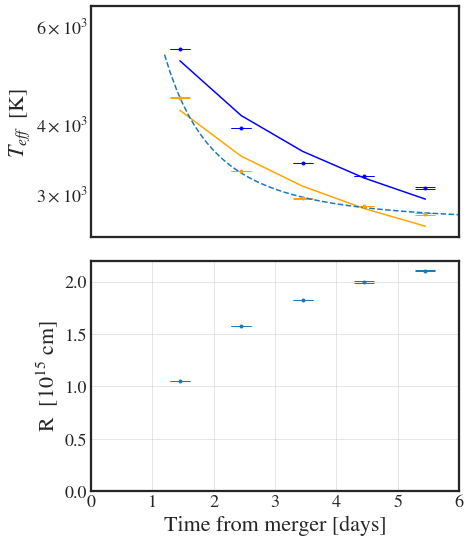

In [37]:
fig,ax = plt.subplots(nrows=2, figsize=(7,8), sharex=True)
#ax[0].errorbar(n_days, v_phot, yerr=2*np.array(dv_phot), fmt='.', capsize=5, alpha=0.5), ax[0].set_ylabel(r'$v_{phot}$')
#ax[0].errorbar(n_days, v_max, yerr =2*np.array(dv_max) , fmt='.', capsize=5)

#ax[0].errorbar(n_days, temp, yerr=dtemp, fmt='.', capsize=10), ax[0].set_ylabel(r'$T_{obs}$ [K]')
#ax[0].errorbar(n_days, temp*(1-v_phot), yerr=dtemp*(1-v_phot), fmt='.', capsize=10)

ax[0].errorbar(n_days, temp, yerr=dtemp, fmt='.', capsize=10, color='blue')
ax[0].plot(n_days, n_days**par[0]*10**(par[1])+const, color='blue' )
#ax[0].plot(n_days, np.array(n_days)**(-0.54)*10**(par[1]), color='blue' , ls = '--')

ax[0].errorbar(n_days, temp/inter(v_phot), yerr=dtemp*inter(v_phot), fmt='.', capsize=10, color='orange')
ax[0].plot(n_days, n_days**par2[0]*10**(par2[1]) + const, color='orange' )

ax[0].set_ylabel(r'$T_{eff}$  [K]')
ax[0].ticklabel_format(axis='y', style='plain'), ax[0].set_ylim(2500,6500)

v_phot = np.array(v_phot)
r_phot = v_phot*c*(np.array(n_days)*3600*24*100)
dr_phot = np.array(dv_phot)*c*(np.array(n_days)*3600*24*100)

ax[1].errorbar(n_days, r_phot/1e15, yerr=dr_phot/1e15, fmt='.', capsize=10), #ax[1].set_ylabel('Temp [K]')
#ax[1].set_yscale('log'), 
ax[1].set_ylim(0, 2.2) #, ax[1].set_xscale('log')
#ax[1].errorbar(n_days, R, yerr=dR, fmt='.', capsize=10), 
ax[1].set_ylabel(r'R  [$10^{15}$ cm]')

#ax[1].plot( np.linspace(0, 6), np.linspace(0, 6*86400)*3e10*0.3/1e15, ls='--' )
#ax[1].plot( np.linspace(0, 6), np.linspace(0, 6*86400)*3e10*0.2/1e15, ls='--' )
#ax[1].plot( np.linspace(0, 6), np.linspace(0, 6*86400)*3e10*0.1/1e15, ls='--' )
ax[0].set_yscale('log'), #ax[1].set_xscale('log')

ax[0].plot(np.linspace(1.2, 6), power_cons(np.linspace(1.2, 6), *p_n), ls='--')

plt.xlim(1, 6), ax[0].grid()
plt.xlim(0,6), plt.xlabel('Time from merger [days]')
plt.tight_layout()
#plt.savefig('Temp_radius_1.png', dpi=300)

In [29]:
const = 0

In [30]:
print(np.polyfit(np.log10(n_days), np.log10(np.array(temp)-const), 1 ))
#par = np.polyfit(np.log10(n_days), np.log10(temp), 1, w = np.array(dtemp)/np.array(temp) ) 
par = np.polyfit(np.log10(n_days), np.log10(np.array(temp)-const), 1 ) 

[-0.43329199  3.78479753]


In [31]:
par2, cov2 = np.polyfit(np.log10(n_days), np.log10((np.array(temp)-const)/inter(v_phot)), 1, cov=True)
p,cov = np.polyfit(np.log10(n_days), np.log10( (np.array(temp)-const)/inter(v_phot)), 1, w = np.array(dtemp)/np.array(temp), cov=True)
p, np.sqrt(np.diagonal(cov))

(array([-0.24344332,  3.61728716]), array([0.0364761 , 0.02636531]))

In [44]:
def power_cons(x, a, b, c): 
    return a + b*x**c

from scipy.optimize import curve_fit
p_n, cov_n = curve_fit(power_cons, n_days, temp/inter(v_phot), p0=[2500, 5000, -1], sigma=dtemp)

In [45]:
(temp/inter(v_phot)-power_cons(n_days, *p_n))/dtemp

array([ -0.41180284,  10.5563224 , -11.62566547,   9.91994092,
        -1.56539134])

In [46]:
p_n, np.sqrt(np.diagonal(cov_n))

(array([ 2.64290867e+03,  3.89991470e+03, -2.06394642e+00]),
 array([ 62.78564733, 178.68894415,   0.20713221]))

In [47]:
2500+3900*2.45**(-2)

3149.729279466889

In [275]:
v_phot

array([0.28265402, 0.25086976, 0.20163787, 0.17441206, 0.14623248])

In [249]:
N_2 = np.copy(N)
N_2[2] = 3.2e-29
N_2[3] = 3.6e-29
N_2/N, N_2, N

(array([1.        , 1.        , 0.81696742, 1.15065779, 1.        ]),
 array([1.36689928e-29, 2.74934583e-29, 3.20000000e-29, 3.60000000e-29,
        3.64340637e-29]),
 [1.3668992808257217e-29,
  2.749345830137273e-29,
  3.9169248650013465e-29,
  3.128645232845264e-29,
  3.6434063723085333e-29])

In [238]:
for idx,day in enumerate(n_days): 
    #print( lum_dist_arr(N[idx], v_phot[idx], n_days=day) )
    print( lum_dist_arr(N_2[idx], v_phot[idx], n_days=day) )

39.374087387295134
39.964980766197144
39.877523685699586
40.63915643167434
40.34971250255255


Lum_dist =  47.118561468914564 + 0.2216025389865024 - 0.3345367308996714
Lum_dist =  46.91233325093216 + 3.9362233995265754 - 0.7784305465631931
Lum_dist =  39.278267600837275 + 0.8163870705975853 - 0.9472192717086614
Lum_dist =  37.079049324534985 + 0.17055167062147802 - 1.4451993181101912


(Text(0.5, 0, '$D_L$ [Mpc]'), Text(0, 0.5, '$p(D_L)$'))

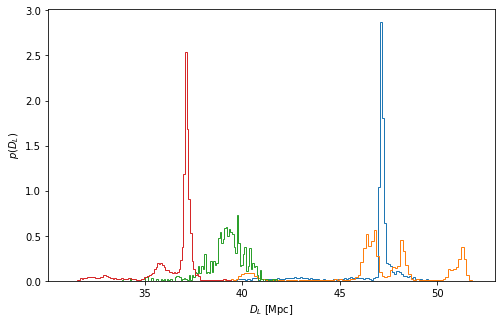

In [12]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'

files = ["./data/s_init_no_gaussian_high_v.pkl", "./data/OB2/OB2_3.pkl", 
        "./data/OB3/OB3_emcee.pkl", "./Data/OB4/OB4_3.pkl"] 

plt.figure(figsize=(8,5))
for idx, file in enumerate(files):
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    vphot = np.array(emcee_flatten['vphot'])
    dl = lum_dist_arr(np.array(emcee_flatten['N']), vphot, n_days=n_days[idx])
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    plt.hist(dl, bins=100, histtype='step', density=True, label='Epoch ')#, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    
    
plt.xlabel(r'$D_L$ [Mpc]'), plt.ylabel(r'$p(D_L)$') 

In [9]:
OB = 'OB1'
#OB1_init_no_gaussian_low_v.pkl
#OB2_init_no_gaussian_low_v.pkl
#"./data/OB3_init_no_gaussian_high_v.pkl", OB3_emcee.pkl

pickle_in = open("./data/OB2_init_no_gaussian_low_v.pkl","rb")
emcee_res = pickle.load(pickle_in)
emcee_flatten = emcee_res.flatchain

50.75829118045746 48.910845429241725 50.879418292534076


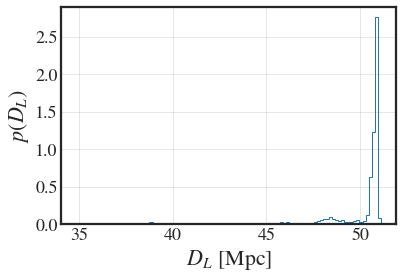

In [10]:
reset_plt(18,22)
vphot = np.array(emcee_flatten['vphot'])
dl = lum_dist_arr(np.array(emcee_flatten['N']), vphot, n_days=2.42) #
#dl = dl[dl>39]
plt.hist(dl, bins=100, histtype='step', density=True);
plt.xlabel(r'$D_L$ [Mpc]'), plt.ylabel(r'$p(D_L)$') 

print(np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)) 

(Text(0.5, 0, '$N$'), Text(0, 0.5, '$p(N)$'))

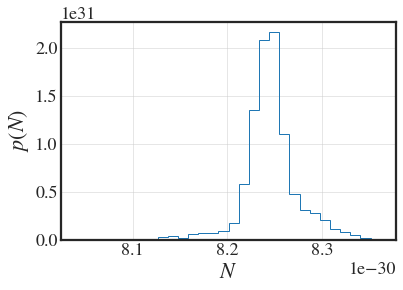

In [11]:
plt.hist(emcee_flatten['N'], bins=30, histtype='step', density=True);
plt.xlabel(r'$N$'), plt.ylabel(r'$p(N)$')

C:\Users\asnep\Anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


(Text(0.5, 0, '$v_e$'), Text(0, 0.5, '$p(v_e)$'))

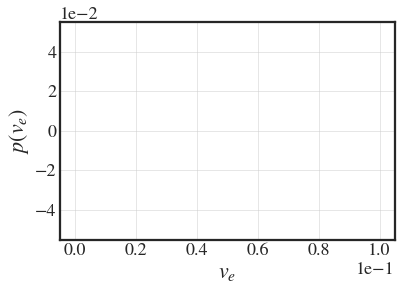

In [12]:
plt.hist(emcee_flatten['ve'], bins=30, histtype='step', density=True, range=(0,0.1));
plt.xlabel(r'$v_e$'), plt.ylabel(r'$p(v_e)$')

In [13]:
emcee_flatten['ve']

0        0.445790
1        0.454133
2        0.422086
3        0.445150
4        0.448434
           ...   
57995    0.715170
57996    0.787073
57997    0.737069
57998    0.906467
57999    0.707515
Name: ve, Length: 58000, dtype: float64

(Text(0.5, 0, '$v_{phot}$ [c]'), Text(0, 0.5, '$p(v_{phot})$'))

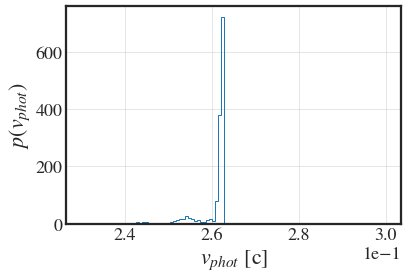

In [14]:
plt.hist(emcee_flatten['vphot'], bins=100, histtype='step', density=True, range=(0.23, 0.3));
plt.xlabel(r'$v_{phot}$ [c]'), plt.ylabel(r'$p(v_{phot})$')

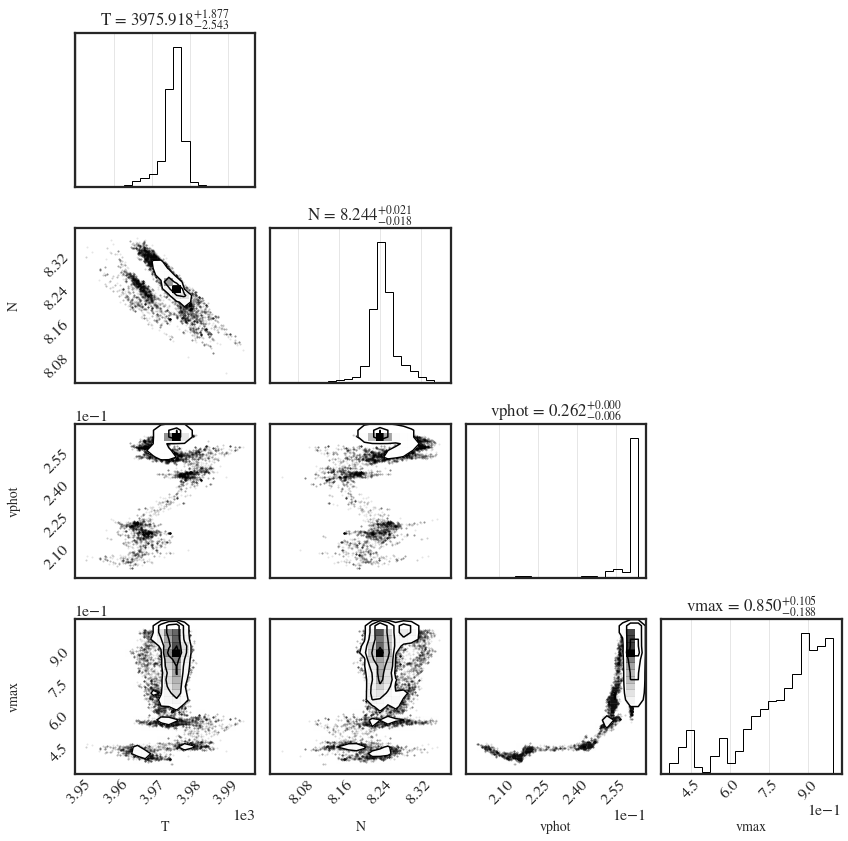

In [17]:
fig,ax = plt.subplots(figsize=(12,12),nrows=4,ncols=4)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([emcee_res.flatchain['T'], emcee_res.flatchain['N']*1e30, emcee_res.flatchain['vphot'],emcee_flatten['ve']]).T, 
                           labels=emcee_res.var_names[:4], show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 
#ax[2].set_xlim(0.286,0.292)
#ax[2][2].set_xlim(0.286,0.293)
#plt.xlabel('')
#put_ticks(fig,ax)

(None, None, None)

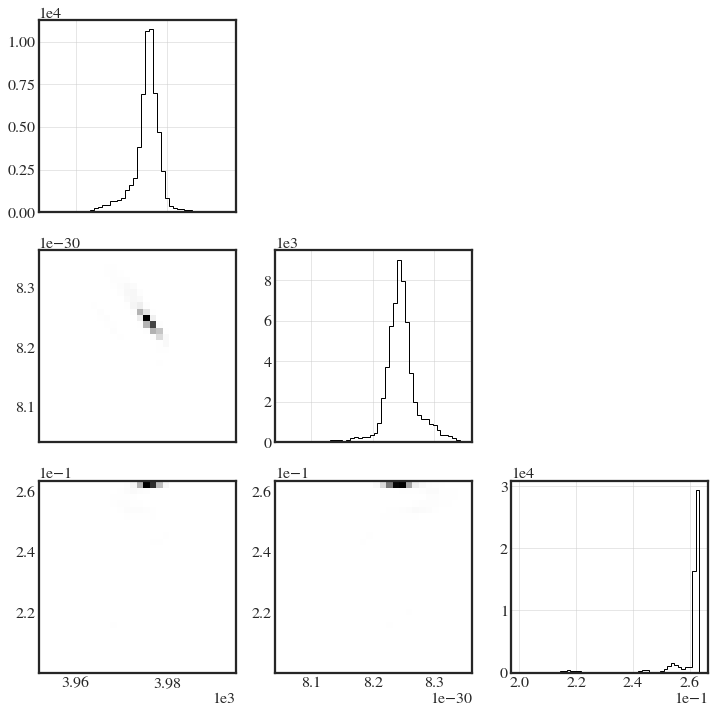

In [16]:
fig,ax = plt.subplots(figsize=(12,12),nrows=3,ncols=3, sharex='col')
ax[0,0].hist(emcee_res.flatchain['T']    , bins=50, histtype='step', color='k'); 
ax[1,1].hist(emcee_res.flatchain['N']    , bins=50, histtype='step', color='k'); 
ax[2,2].hist(emcee_res.flatchain['vphot'], bins=50, histtype='step', color='k'); 

ax[1,0].hist2d(emcee_res.flatchain['T'],emcee_res.flatchain['N'], bins=30); 
ax[2,0].hist2d(emcee_res.flatchain['T'],emcee_res.flatchain['vphot'], bins=30); 
ax[2,1].hist2d(emcee_res.flatchain['N'],emcee_res.flatchain['vphot'], bins=30); 

fig.delaxes(ax[0,1]), fig.delaxes(ax[0,2]), fig.delaxes(ax[1,2])

In [64]:
os.cpu_count()

4

In [72]:
list(res.params.valuesdict().values())

NameError: name 'res' is not defined

ValueError: Provided figure has 169 axes, but data has dimensions K=15

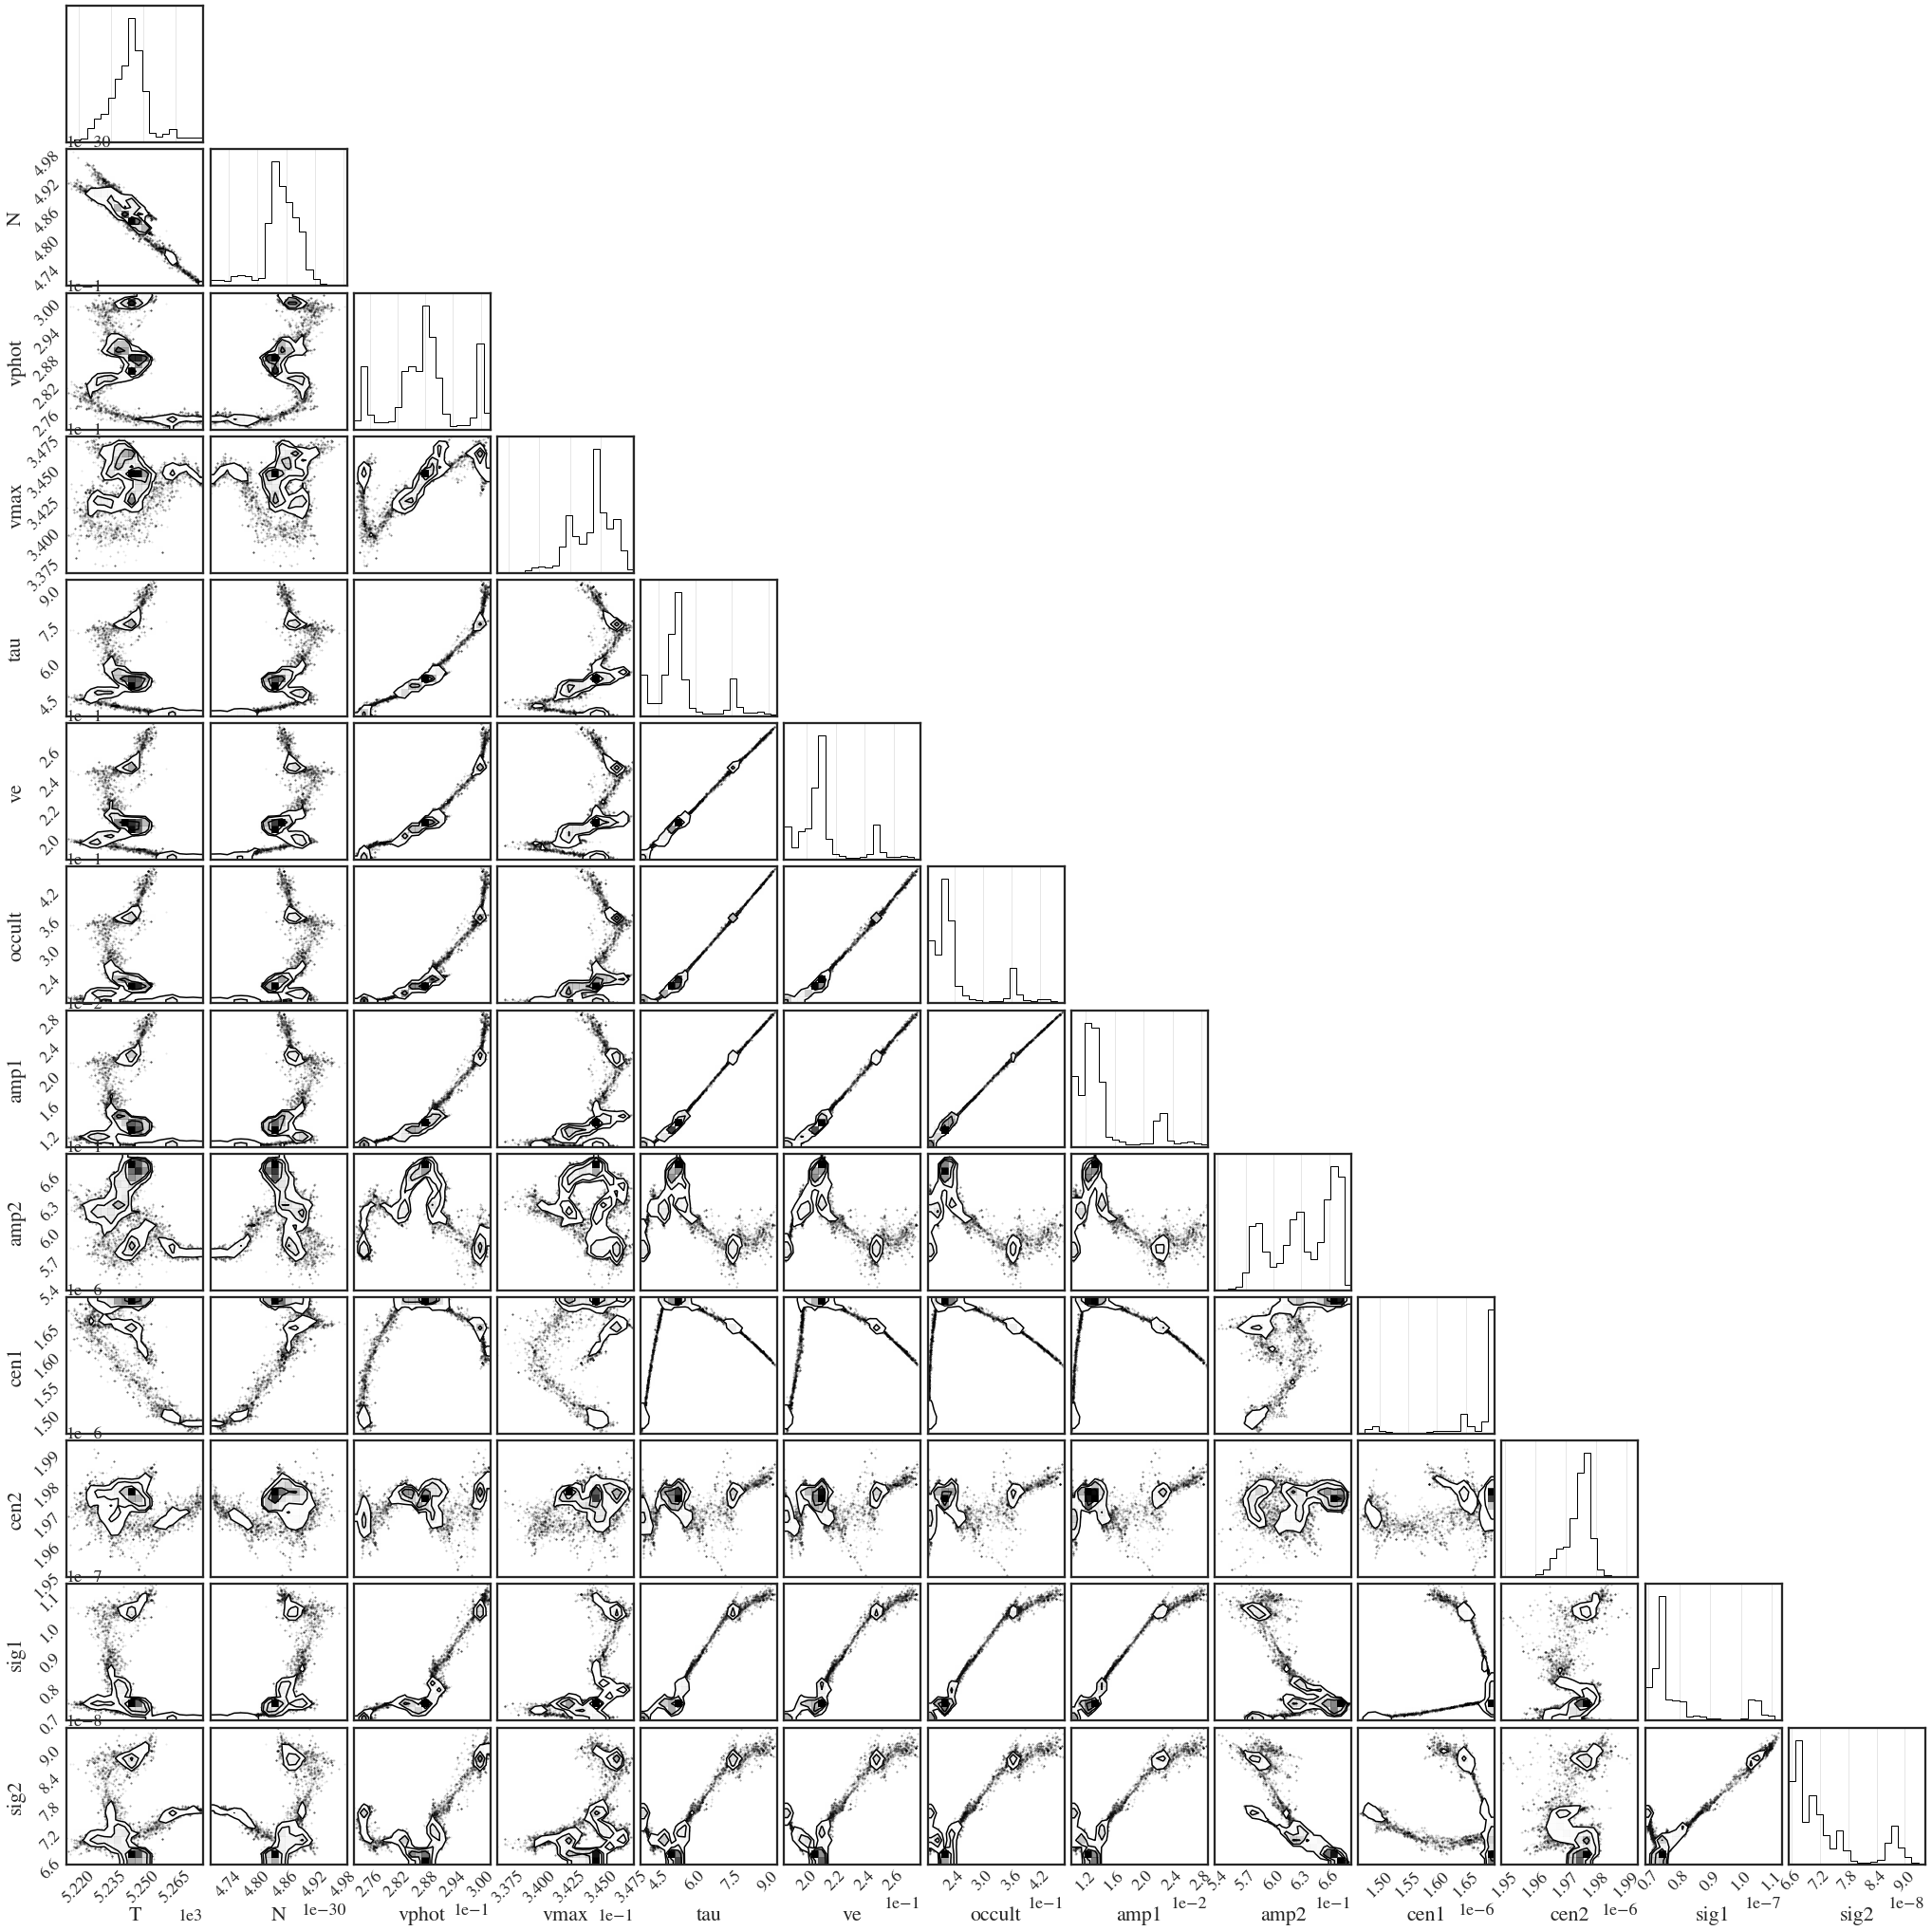

In [73]:
emcee_corner = corner.corner(emcee_res.flatchain, labels=emcee_res.var_names,
                             truths=list(emcee_res.params.valuesdict().values()))

In [75]:
dir(emcee_res)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_calculate_statistics',
 '_repr_html_',
 'aborted',
 'acceptance_fraction',
 'aic',
 'bic',
 'call_kws',
 'chain',
 'chisqr',
 'errorbars',
 'flatchain',
 'init_vals',
 'init_values',
 'lnprob',
 'method',
 'ndata',
 'nfev',
 'nfree',
 'nvarys',
 'params',
 'redchi',
 'residual',
 'show_candidates',
 'var_names']

In [80]:
np.shape(emcee_res.chain)

(900, 30, 13)

In [92]:
emcee_res.chain[0,:,0]

array([5275.70626546, 5276.65545182, 5275.05370091, 5272.46181122,
       5276.39029026, 5269.37109804, 5268.64294083, 5276.59924695,
       5271.93875701, 5272.87631862, 5277.5533412 , 5274.5834263 ,
       5274.41448687, 5275.43339118, 5272.26635756, 5274.44453961,
       5276.22332763, 5275.35760111, 5276.03497717, 5274.01119549,
       5275.88834534, 5276.51569039, 5274.63362741, 5275.89335662,
       5275.12868792, 5277.34749097, 5268.14121194, 5276.80196003,
       5272.76594584, 5277.61273616])

In [91]:
emcee_res.chain[-1,:,0]

array([5251.40559222, 5251.395244  , 5250.30797093, 5251.37094154,
       5252.55964554, 5247.31159301, 5249.6375852 , 5255.29087494,
       5251.09430822, 5253.34290038, 5250.19483399, 5248.32828646,
       5253.90408282, 5249.37678089, 5250.28535868, 5249.03402164,
       5249.4664192 , 5249.8772084 , 5253.48892266, 5252.36440293,
       5251.67994971, 5251.26262821, 5246.85374736, 5251.63612599,
       5249.61857087, 5248.24931779, 5253.37405259, 5251.23152411,
       5252.2752464 , 5251.63974589])

(array([ 75.,  49.,  27., 112., 227., 166.,  77.,  13.,  20., 134.]),
 array([0.2737341 , 0.27648891, 0.27924371, 0.28199851, 0.28475331,
        0.28750812, 0.29026292, 0.29301772, 0.29577252, 0.29852733,
        0.30128213]),
 <BarContainer object of 10 artists>)

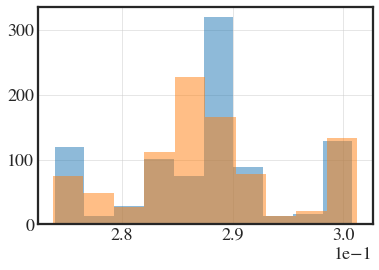

In [96]:
plt.hist(emcee_res.chain[:,0,2], alpha=0.5)
plt.hist(emcee_res.chain[:,1,2], alpha=0.5)

In [70]:
0.011/.0098

1.1224489795918366

In [114]:
0.0098*c*1e-3/40.6

72.41379310344827

In [ ]:
#files = ["./data/OB1_init_no_gaussian_low_v.pkl", "./data/OB2_init_no_gaussian_low_v.pkl", 
#        "./data/OB3_init_no_gaussian_high_v.pkl", "./Data/OB4/OB4_3.pkl"] #'OB4_pick.pkl'
#n_days = [1.43, 2.42, 3.65, 4., 5.40]
n_days = [1.435, 2.42, 3.42, 4.40, 5.40]

files = ["./data/OB1/OB1_3_peaks_XL_3.pkl", "./data/OB2/OB2_3_peaks_XL_2.pkl", 
        "./data/OB3/OB3_3_peaks_XL_4.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl", 
        "./Data/OB5/OB5_3_peaks_XL.pkl"] 
#files = ["./data/OB1/OB1_3_peaks_free_ve.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl"] 

reset_plt(18,22)
plt.figure(figsize=(8,5))

steady = [10000, 1000, 100000, 1000, 0, 0]

d_m, ds_1, ds_2 = [], [], []
multi = [1, 1, 1, 1, 1, 1]
#multi = [np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi), np.sqrt(np.pi)]

pdf_list = []
for idx, file in enumerate(files[:2]):
    pickle_in = open(file,"rb")
    emcee_res = pickle.load(pickle_in)
    emcee_flatten = emcee_res.flatchain
    
    vphot = np.array(emcee_flatten['vphot'])
    dl = lum_dist_arr(np.array(emcee_flatten['N']), vphot, n_days=n_days[idx])[steady[idx]:]*multi[idx]
                      #emcee_res.params['t0'].value/86400)#n_days[idx])
    
    h = plt.hist(dl, bins=250, histtype='step', density=True, label='Epoch '+str(idx+1), range=(38,42))
    pdf_list.append(h[0])
    #plt.hist(dl, bins=100, histtype='stepfilled', density=True, alpha=0.2)
    #, range=(35,50));
    d1, d_l, d_h = np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9)
    d_m.append(d1); ds_1.append(d1-d_l), ds_2.append(d_h-d1)
    print('Lum_dist = ', d1, '+', d_h-d1, '-', d1-d_l)
    print(emcee_res.params['ve'])
    print(np.median(emcee_flatten['N']))

d_m = np.array(d_m); ds_1 = np.array(ds_1); ds_2 = np.array(ds_2)
    
plt.legend()
plt.xlabel(r'$D_L$ [Mpc]'), plt.ylabel(r'$p(D_L)$') 
plt.xlim(39, 41)

#plt.savefig('Pictures/dl_dist_3.png', dpi=300)